Original dataset shape: (783, 46)

Average years between disaster occurrences:
Drought: 8.4 years
Earthquake: 5.0 years
Epidemic: 3.9 years
Extreme temperature: 1.7 years
Flood: 1.5 years
Glacial lake outburst flood: 2.0 years
Mass movement (dry): 23.0 years
Mass movement (wet): 2.2 years
Storm: 1.4 years
Wildfire: 11.3 years

Classification Report for Drought:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       192
           1       0.00      0.00      0.00         4

    accuracy                           0.97       196
   macro avg       0.49      0.49      0.49       196
weighted avg       0.96      0.97      0.96       196


Classification Report for Earthquake:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       188
           1       0.00      0.00      0.00         8

    accuracy                           0.95       196
   macro avg       0.48      0.50      0.49       19

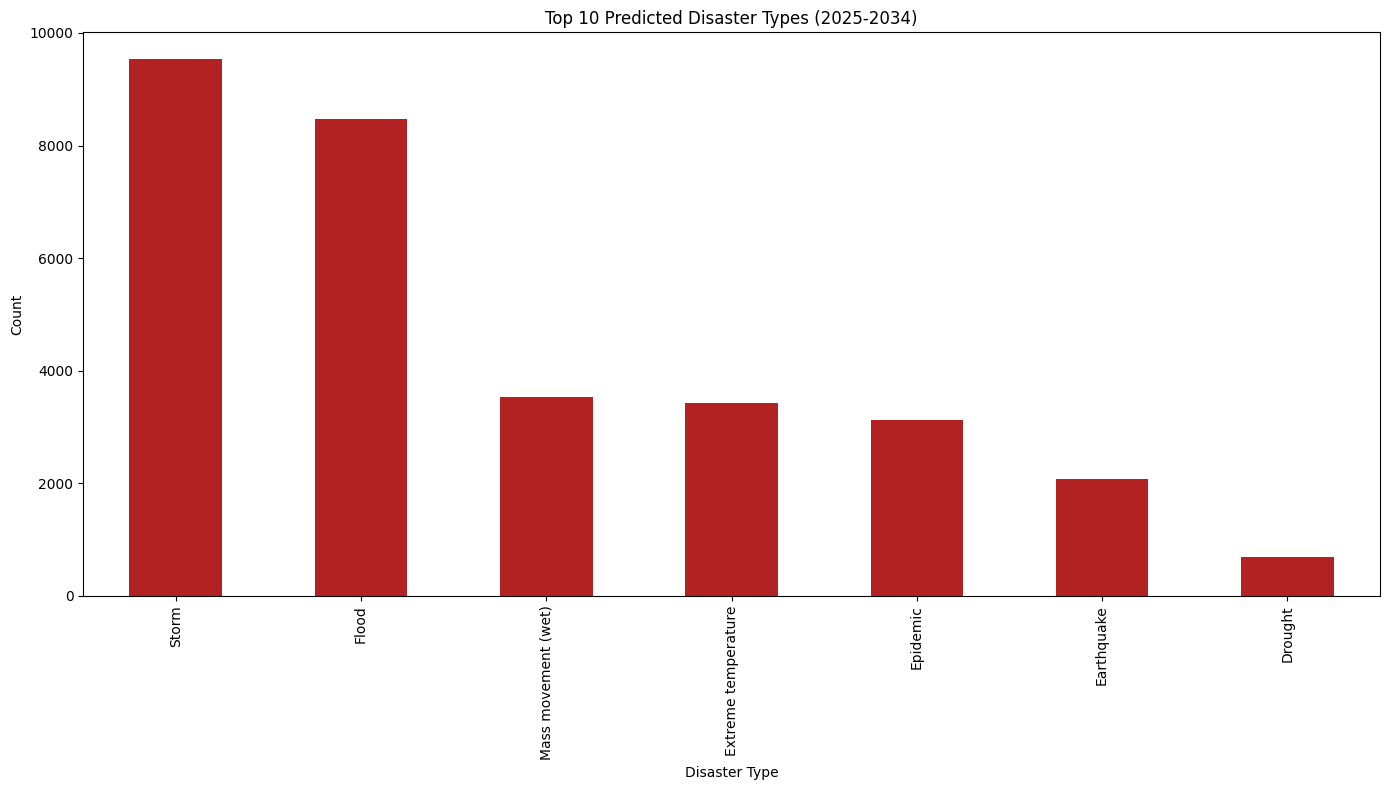

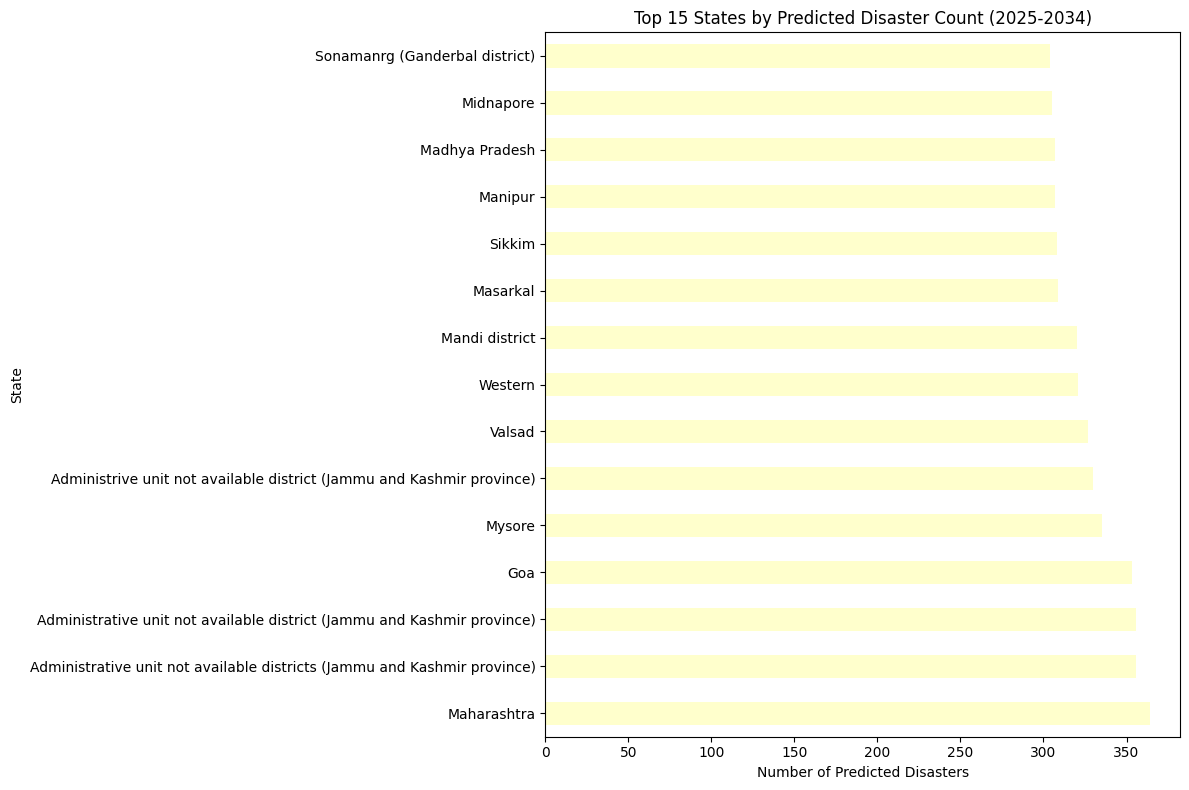

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import calendar
from sklearn.metrics import classification_report
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('disasterIND.csv', sep=',')

# Step 1: Data Exploration and Cleaning
print("Original dataset shape:", df.shape)

# Convert date columns to datetime
date_columns = ['Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create a start date column
df['Start_Date'] = pd.to_datetime(
    dict(year=df['Start Year'], month=df['Start Month'], day=df['Start Day']),
    errors='coerce'
)

# Create a simplified month column 
df['Month'] = pd.to_numeric(df['Start Month'], errors='coerce').fillna(1).astype(int)

# Create season column
def get_season(month):
    if pd.isna(month) or month == 0:
        return 'Unknown'
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Autumn'

# Apply the function to create season
df['Season'] = df['Month'].apply(get_season)

# Handle missing values for key columns
for col in ['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Location']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Step 2: Enhanced Feature Engineering
# Extract state from location
def extract_state(location_str):
    if pd.isna(location_str):
        return 'Unknown'
    
    states = [
        'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'Goa', 'Gujarat', 
        'Haryana', 'Himachal Pradesh', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 
        'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 
        'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Delhi',
        'Bengal'
    ]
    
    for state in states:
        if state.lower() in location_str.lower():
            return state
    
    return location_str.split(',')[0] if ',' in location_str else location_str

# Apply the state extraction
df['State'] = df['Location'].apply(extract_state)

# Create climate zone feature
def assign_climate_zone(state):
    # Define climate zones for Indian states
    tropical = ['Kerala', 'Tamil Nadu', 'Karnataka', 'Andhra Pradesh', 'Telangana', 'Goa']
    subtropical = ['Maharashtra', 'Madhya Pradesh', 'Chhattisgarh', 'Odisha', 'West Bengal', 'Bengal']
    arid = ['Rajasthan', 'Gujarat']
    semi_arid = ['Punjab', 'Haryana', 'Delhi', 'Uttar Pradesh']
    montane = ['Himachal Pradesh', 'Uttarakhand', 'Jammu and Kashmir', 'Sikkim', 'Arunachal Pradesh']
    humid_subtropical = ['Assam', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura', 'Bihar', 'Jharkhand']
    
    if state in tropical:
        return 'Tropical'
    elif state in subtropical:
        return 'Subtropical'
    elif state in arid:
        return 'Arid'
    elif state in semi_arid:
        return 'Semi-Arid'
    elif state in montane:
        return 'Montane'
    elif state in humid_subtropical:
        return 'Humid Subtropical'
    else:
        return 'Unknown'

df['Climate_Zone'] = df['State'].apply(assign_climate_zone)

# Create coastal state feature
coastal_states = ['Gujarat', 'Maharashtra', 'Goa', 'Karnataka', 'Kerala', 'Tamil Nadu', 
                  'Andhra Pradesh', 'Odisha', 'West Bengal', 'Bengal']
df['Is_Coastal'] = df['State'].apply(lambda x: 1 if x in coastal_states else 0)

# Create geographical region feature
def assign_region(state):
    north = ['Jammu and Kashmir', 'Himachal Pradesh', 'Punjab', 'Haryana', 'Uttarakhand', 'Delhi']
    central = ['Rajasthan', 'Uttar Pradesh', 'Madhya Pradesh', 'Chhattisgarh']
    east = ['Bihar', 'Jharkhand', 'West Bengal', 'Bengal', 'Odisha']
    northeast = ['Sikkim', 'Assam', 'Arunachal Pradesh', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura']
    west = ['Gujarat', 'Maharashtra', 'Goa']
    south = ['Karnataka', 'Telangana', 'Andhra Pradesh', 'Tamil Nadu', 'Kerala']
    
    if state in north:
        return 'North'
    elif state in central:
        return 'Central'
    elif state in east:
        return 'East'
    elif state in northeast:
        return 'Northeast'
    elif state in west:
        return 'West'
    elif state in south:
        return 'South'
    else:
        return 'Unknown'

df['Region'] = df['State'].apply(assign_region)

# Create severity indicator based on deaths and affected
df['Total Deaths'] = pd.to_numeric(df['Total Deaths'], errors='coerce').fillna(0)
df['Total Affected'] = pd.to_numeric(df['Total Affected'], errors='coerce').fillna(0)
df['Severity'] = np.log1p(df['Total Deaths'] + 0.1*df['Total Affected'])

# Step 3: Calculate disaster frequencies and patterns
# Get disaster frequency by type, state, and month
disaster_type_freq = df.groupby('Disaster Type').size().to_dict()
state_disaster_freq = df.groupby(['State', 'Disaster Type']).size().unstack(fill_value=0)
month_disaster_freq = df.groupby(['Month', 'Disaster Type']).size().unstack(fill_value=0)
season_disaster_freq = df.groupby(['Season', 'Disaster Type']).size().unstack(fill_value=0)
climate_disaster_freq = df.groupby(['Climate_Zone', 'Disaster Type']).size().unstack(fill_value=0)

# Calculate disaster periodicity
yearly_disasters = df.groupby(['Start Year', 'Disaster Type']).size().unstack(fill_value=0)
disaster_periodicity = {}

for disaster in df['Disaster Type'].unique():
    disaster_data = yearly_disasters.get(disaster, pd.Series())
    if not disaster_data.empty:
        # Find years with disasters
        years_with_disasters = disaster_data[disaster_data > 0].index.tolist()
        if len(years_with_disasters) >= 2:
            # Calculate intervals between occurrences
            intervals = [years_with_disasters[i+1] - years_with_disasters[i] 
                        for i in range(len(years_with_disasters)-1)]
            if intervals:
                avg_interval = sum(intervals) / len(intervals)
                disaster_periodicity[disaster] = round(avg_interval, 1)

print("\nAverage years between disaster occurrences:")
for disaster, period in sorted(disaster_periodicity.items()):
    print(f"{disaster}: {period} years")

# Step 4: Prepare features for prediction models
# Define features to use
features = ['Month', 'Season', 'State', 'Climate_Zone', 'Region', 'Is_Coastal']
disaster_types = df['Disaster Type'].unique()

# Create a copy of the dataframe for processing
df_proc = df.copy()

# Encode categorical variables consistently
label_encoders = {}
for column in features:
    if column in df_proc.columns and df_proc[column].dtype == 'object':
        le = LabelEncoder()
        df_proc[column] = le.fit_transform(df_proc[column])
        label_encoders[column] = le
    elif column == 'Is_Coastal':  # Already numeric
        pass

# Get the feature matrix X
X = df_proc[features].copy()

# Step 5: Build prediction models for each disaster type
disaster_models = {}
disaster_classes = {}  # Store number of classes for each disaster type model

for disaster in disaster_types:
    # Create binary target: 1 if this disaster, 0 otherwise
    y_binary = (df['Disaster Type'] == disaster).astype(int)
    
    # Check if we have enough positive samples
    positive_samples = sum(y_binary)
    if positive_samples < 5:
        print(f"Warning: Not enough samples for {disaster} ({positive_samples} found). Skipping.")
        continue
    
    # Use consistent features
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.25, random_state=42)
    
    # Train a Random Forest model for this disaster type
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Store the model
    disaster_models[disaster] = rf_model
    
    # Store number of classes - important for prediction
    disaster_classes[disaster] = len(np.unique(y_train))
    
    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    print(f"\nClassification Report for {disaster}:")
    print(classification_report(y_test, y_pred))

# Step 6: Generate future predictions for 10 years (2025-2034)
# Create future years dataframe with exactly the same columns and transformations
future_years = range(2025, 2035)  # 10 years
months = range(1, 13)
states = df['State'].unique()

future_data = []
for year in future_years:
    for month in months:
        for state in states:
            future_data.append([year, month, state])

future_df = pd.DataFrame(future_data, columns=['Year', 'Month', 'State'])

# Add derived features using the same functions as before
future_df['Season'] = future_df['Month'].apply(get_season)
future_df['Climate_Zone'] = future_df['State'].apply(assign_climate_zone)
future_df['Is_Coastal'] = future_df['State'].apply(lambda x: 1 if x in coastal_states else 0)
future_df['Region'] = future_df['State'].apply(assign_region)

# Encode categorical features using the same encoders from training
future_df_encoded = future_df.copy()
for column in features:
    if column in label_encoders:  # For categorical columns
        # Map values not seen during training to a value that was seen
        future_df_encoded[column] = future_df[column].apply(
            lambda x: x if x in label_encoders[column].classes_ else label_encoders[column].classes_[0]
        )
        future_df_encoded[column] = label_encoders[column].transform(future_df_encoded[column])

# Ensure future_X has exactly the same columns as X, in the same order
future_X = future_df_encoded[features].copy()

# Step 7: Make predictions for each disaster type
for disaster, model in disaster_models.items():
    # Check how many classes this model has - fixes the IndexError
    num_classes = disaster_classes[disaster]
    
    # Get the probabilities
    probs = model.predict_proba(future_X)
    
    # If there's only one class (all negative), set probability to 0
    if num_classes == 1 or probs.shape[1] == 1:
        future_df[f"Prob_{disaster}"] = 0
    else:
        # Otherwise use the probability of the positive class (index 1)
        future_df[f"Prob_{disaster}"] = probs[:, 1]

# Step 8: Apply adjustments based on historical patterns
for idx, row in future_df.iterrows():
    month = row['Month']
    state = row['State']
    season = row['Season']
    climate = row['Climate_Zone']
    
    for disaster in disaster_models.keys():
        base_prob = row[f"Prob_{disaster}"]
        
        # Seasonal adjustment
        season_factor = 1.0
        if season in season_disaster_freq.index and disaster in season_disaster_freq.columns:
            if season_disaster_freq.loc[season, disaster] > 0:
                season_factor = 1.2
        
        # Monthly adjustment
        month_factor = 1.0
        if month in month_disaster_freq.index and disaster in month_disaster_freq.columns:
            if month_disaster_freq.loc[month, disaster] > 0:
                month_factor = 1.3
        
        # State history adjustment
        state_factor = 1.0
        if state in state_disaster_freq.index and disaster in state_disaster_freq.columns:
            if state_disaster_freq.loc[state, disaster] > 0:
                state_factor = 1.5
        
        # Climate zone adjustment
        climate_factor = 1.0
        if climate in climate_disaster_freq.index and disaster in climate_disaster_freq.columns:
            if climate_disaster_freq.loc[climate, disaster] > 0:
                climate_factor = 1.2
        
        # Apply periodicity factor if available
        periodicity_factor = 1.0
        if disaster in disaster_periodicity:
            period = disaster_periodicity[disaster]
            last_occurrence = df[df['Disaster Type'] == disaster]['Start Year'].max()
            if not pd.isna(last_occurrence):
                years_since_last = row['Year'] - last_occurrence
                # If we're close to a predicted recurrence
                if abs(years_since_last % period) <= 1:
                    periodicity_factor = 1.5
        
        # Calculate final adjusted probability
        adjusted_prob = base_prob * season_factor * month_factor * state_factor * climate_factor * periodicity_factor
        
        # Cap at 1.0
        future_df.loc[idx, f"Adj_Prob_{disaster}"] = min(1.0, adjusted_prob)

# Step 9: Format predictions for analysis
# Get all adjusted probability columns
adj_prob_cols = [col for col in future_df.columns if col.startswith('Adj_Prob_')]

# Find the most likely disaster type for each location and time
future_df['Most_Likely_Disaster'] = future_df[adj_prob_cols].idxmax(axis=1).str.replace('Adj_Prob_', '')
future_df['Max_Probability'] = future_df[adj_prob_cols].max(axis=1)

# Create a threshold for significant disaster probability
threshold = 0.3
significant_predictions = future_df[future_df['Max_Probability'] >= threshold].copy()

# Format month as name
significant_predictions['Month_Name'] = significant_predictions['Month'].apply(
    lambda x: calendar.month_name[int(x)]
)

# Step 10: Generate comprehensive prediction table
prediction_results = []

for idx, row in significant_predictions.iterrows():
    year = row['Year']
    month = row['Month_Name']
    state = row['State']
    
    # Get all disasters with significant probability
    for disaster in disaster_models.keys():
        prob = row[f"Adj_Prob_{disaster}"]
        if prob >= threshold:
            prediction_results.append({
                'Year': year,
                'Month': month,
                'State': state,
                'Disaster Type': disaster,
                'Probability': prob,
                'Climate Zone': row['Climate_Zone'],
                'Season': row['Season'],
                'Region': row['Region']
            })

# Convert to DataFrame and sort
prediction_df = pd.DataFrame(prediction_results)
if not prediction_df.empty:
    prediction_df = prediction_df.sort_values(by=['Year', 'Month', 'State', 'Probability'], ascending=[True, True, True, False])
    
    # Format probability as percentage for display
    prediction_df['Probability_Pct'] = prediction_df['Probability'].apply(lambda x: f"{x:.2%}")
    
    # Save the predictions to a CSV file
    prediction_df.to_csv('comprehensive_disaster_predictions_2025_2034.csv', index=False)
    
    print("\nComprehensive Disaster Predictions for 2025-2034:")
    print(prediction_df.head(20).to_string(index=False))
    
    # Step 11: Generate location-specific disaster profiles
    location_profiles = []
    
    for state in df['State'].unique():
        state_predictions = prediction_df[prediction_df['State'] == state]
        if not state_predictions.empty:
            disaster_counts = state_predictions['Disaster Type'].value_counts()
            
            profile = {
                'State': state,
                'Climate Zone': state_predictions['Climate Zone'].iloc[0],
                'Region': state_predictions['Region'].iloc[0],
                'Total Predicted Disasters': len(state_predictions),
                'Most Common Disaster': disaster_counts.index[0],
                'Most Common Disaster Count': disaster_counts.iloc[0],
                'All Potential Disasters': ', '.join(disaster_counts.index.tolist())
            }
            location_profiles.append(profile)
    
    location_profiles_df = pd.DataFrame(location_profiles)
    if not location_profiles_df.empty:
        location_profiles_df = location_profiles_df.sort_values('Total Predicted Disasters', ascending=False)
        location_profiles_df.to_csv('location_disaster_profiles_2025_2034.csv', index=False)
        
        print("\nLocation-Specific Disaster Profiles (Top 10):")
        print(location_profiles_df.head(10).to_string(index=False))
    
    # Step 12: Generate yearly disaster summary
    yearly_summary = prediction_df.groupby(['Year', 'Disaster Type']).size().unstack(fill_value=0)
    yearly_summary.to_csv('yearly_disaster_summary_2025_2034.csv')
    
    print("\nYearly Disaster Summary (2025-2034):")
    print(yearly_summary.to_string())
    
    # Step 13: Visualize key findings
    try:
        plt.figure(figsize=(14, 8))
        disaster_counts = prediction_df['Disaster Type'].value_counts().head(10)
        disaster_counts.plot(kind='bar', color='firebrick')
        plt.title('Top 10 Predicted Disaster Types (2025-2034)')
        plt.xlabel('Disaster Type')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig('top_predicted_disasters.png')
        
        # Map of disaster hotspots
        plt.figure(figsize=(12, 8))
        state_counts = prediction_df['State'].value_counts().head(15)
        state_counts.plot(kind='barh', cmap='YlOrRd')
        plt.title('Top 15 States by Predicted Disaster Count (2025-2034)')
        plt.xlabel('Number of Predicted Disasters')
        plt.tight_layout()
        plt.savefig('state_disaster_predictions.png')
    except Exception as e:
        print(f"Warning: Could not generate some visualizations: {e}")
    
    print("\nAnalysis complete! Output files have been saved.")
else:
    print("\nNo significant disaster predictions were found for 2025-2034.")

# ----- NEW INTERACTIVE PREDICTION QUERY FUNCTIONS -----

# Store predictions globally for easy access
global_predictions = prediction_df if 'prediction_df' in locals() and not prediction_df.empty else None
global_location_profiles = location_profiles_df if 'location_profiles_df' in locals() and not location_profiles_df.empty else None
global_yearly_summary = yearly_summary if 'yearly_summary' in locals() and not yearly_summary.empty else None

def query_predictions(location=None, year=None, month=None, disaster_type=None, min_probability=0.3):
    """
    Query disaster predictions based on various criteria
    
    Parameters:
    -----------
    location : str, optional
        State or region name
    year : int or list, optional
        Specific year or range of years
    month : str or list, optional
        Month name(s) to query
    disaster_type : str or list, optional
        Specific disaster type(s) to query
    min_probability : float, optional
        Minimum probability threshold (0-1)
        
    Returns:
    --------
    pandas.DataFrame
        Filtered prediction results
    """
    if global_predictions is None:
        print("No prediction data available. Please run the model first.")
        return None
    
    # Start with all predictions
    filtered = global_predictions.copy()
    
    # Filter by location (check both state and region)
    if location:
        location_lower = location.lower()
        filtered = filtered[
            (filtered['State'].str.lower().str.contains(location_lower)) | 
            (filtered['Region'].str.lower().str.contains(location_lower))
        ]
    
    # Filter by year
    if year:
        if isinstance(year, list):
            filtered = filtered[filtered['Year'].isin(year)]
        else:
            filtered = filtered[filtered['Year'] == year]
    
    # Filter by month
    if month:
        if isinstance(month, str):
            # Handle both full month names and abbreviations
            month_upper = month.upper()
            filtered = filtered[filtered['Month'].str.upper().str.contains(month_upper)]
        elif isinstance(month, list):
            # Convert all to uppercase for case-insensitive comparison
            filtered = filtered[filtered['Month'].str.upper().isin([m.upper() for m in month])]
    
    # Filter by disaster type
    if disaster_type:
        if isinstance(disaster_type, list):
            disaster_types_lower = [d.lower() for d in disaster_type]
            filtered = filtered[filtered['Disaster Type'].str.lower().isin(disaster_types_lower)]
        else:
            disaster_type_lower = disaster_type.lower()
            filtered = filtered[filtered['Disaster Type'].str.lower().str.contains(disaster_type_lower)]
    
    # Filter by probability
    filtered = filtered[filtered['Probability'] >= min_probability]
    
    # Sort by probability (descending), year, month
    return filtered.sort_values(by=['Probability', 'Year', 'Month'], ascending=[False, True, True])

def get_location_profile(location):
    """
    Get disaster profile for a specific location
    
    Parameters:
    -----------
    location : str
        State or region name
    
    Returns:
    --------
    pandas.DataFrame
        Location profile information
    """
    if global_location_profiles is None:
        print("No location profile data available. Please run the model first.")
        return None
    
    location_lower = location.lower()
    return global_location_profiles[
        global_location_profiles['State'].str.lower().str.contains(location_lower) | 
        global_location_profiles['Region'].str.lower().str.contains(location_lower)
    ]

def get_highest_risk_locations(disaster_type=None, top_n=5):
    """
    Get locations with highest disaster risk
    
    Parameters:
    -----------
    disaster_type : str, optional
        Specific disaster type to filter by
    top_n : int, optional
        Number of top locations to return (default 5)
    
    Returns:
    --------
    pandas.DataFrame
        Top risk locations
    """
    if global_location_profiles is None:
        print("No location profile data available. Please run the model first.")
        return None
    
    if disaster_type:
        # Filter locations where the specified disaster is the most common
        filtered = global_location_profiles[
            global_location_profiles['Most Common Disaster'].str.lower() == disaster_type.lower()
        ]
        return filtered.sort_values('Total Predicted Disasters', ascending=False).head(top_n)
    else:
        return global_location_profiles.sort_values('Total Predicted Disasters', ascending=False).head(top_n)

def get_yearly_forecast(disaster_type=None, start_year=None, end_year=None):
    """
    Get yearly forecast for all or specific disaster types
    
    Parameters:
    -----------
    disaster_type : str, optional
        Specific disaster type to filter by
    start_year : int, optional
        Start year for the forecast period
    end_year : int, optional
        End year for the forecast period
    
    Returns:
    --------
    pandas.DataFrame
        Yearly forecast data
    """
    if global_yearly_summary is None:
        print("No yearly summary data available. Please run the model first.")
        return None
    
    # Filter by year range if specified
    yearly_data = global_yearly_summary.copy()
    if start_year or end_year:
        if start_year:
            yearly_data = yearly_data[yearly_data.index.get_level_values('Year') >= start_year]
        if end_year:
            yearly_data = yearly_data[yearly_data.index.get_level_values('Year') <= end_year]
    
    # Filter by disaster type if specified
    if disaster_type:
        if disaster_type in yearly_data.columns:
            return yearly_data[disaster_type]
        else:
            disaster_type_lower = disaster_type.lower()
            matching_cols = [col for col in yearly_data.columns if disaster_type_lower in col.lower()]
            if matching_cols:
                return yearly_data[matching_cols]
            else:
                print(f"No data found for disaster type: {disaster_type}")
                return None
    
    return yearly_data

def predict_disasters(query_text):
    """
    Parse a natural language query about disaster predictions and return relevant results
    
    Parameters:
    -----------
    query_text : str
        Natural language query about disaster predictions
    
    Returns:
    --------
    str
        Response to the query with relevant prediction information
    """
    query_text = query_text.lower()
    
    # Check if we have prediction data available
    if global_predictions is None:
        return "No prediction data is available. Please run the model first to generate predictions."
    
    # Extract potential location
    all_states = set(global_predictions['State'].unique())
    all_regions = set(global_predictions['Region'].unique())
    location = None
    
    for state in all_states:
        if state.lower() in query_text:
            location = state
            break
    
    if location is None:
        for region in all_regions:
            if region.lower() in query_text:
                location = region
                break
    
    # Extract potential year
    year = None
    for possible_year in range(2025, 2035):
        if str(possible_year) in query_text:
            year = possible_year
            break
    
    # Extract potential disaster type
    all_disaster_types = set(global_predictions['Disaster Type'].unique())
    disaster_type = None
    
    for dtype in all_disaster_types:
        if dtype.lower() in query_text:
            disaster_type = dtype
            break
    
    # Extract potential month
    all_months = ['january', 'february', 'march', 'april', 'may', 'june', 
                 'july', 'august', 'september', 'october', 'november', 'december']
    month = None
    
    for m in all_months:
        if m in query_text:
            month = m.capitalize()
            break
    
    # Handle different types of queries
    if "highest risk" in query_text or "most at risk" in query_text:
        if disaster_type:
            top_locations = get_highest_risk_locations(disaster_type, top_n=5)
            if top_locations is not None and not top_locations.empty:
                response = f"Top 5 locations at highest risk for {disaster_type}:\n"
                for i, (_, row) in enumerate(top_locations.iterrows(), 1):
                    response += f"{i}. {row['State']} ({row['Total Predicted Disasters']} predicted occurrences)\n"
                return response
            else:
                return f"No high-risk locations found for {disaster_type}."
        else:
            top_locations = get_highest_risk_locations(top_n=5)
            if top_locations is not None and not top_locations.empty:
                response = f"Top 5 locations at highest overall disaster risk:\n"
                for i, (_, row) in enumerate(top_locations.iterrows(), 1):
                    response += f"{i}. {row['State']} ({row['Total Predicted Disasters']} predicted disasters, " \
                              f"most common: {row['Most Common Disaster']})\n"
                return response
            else:
                return "No high-risk locations found in the prediction data."
    
    # Query for specific predictions
    filtered = query_predictions(location=location, year=year, month=month, disaster_type=disaster_type)
    
    if filtered is None or filtered.empty:
        response_parts = []
        if location:
            response_parts.append(f"for {location}")
        if year:
            response_parts.append(f"in {year}")
        if month:
            response_parts.append(f"during {month}")
        if disaster_type:
            response_parts.append(f"of type {disaster_type}")
        
        if response_parts:
            return f"No significant disaster predictions found {' '.join(response_parts)}."
        else:
            return "No significant disaster predictions found matching your query."
    
    # Format response based on the query
    if location and year and month and disaster_type:
        response = f"Prediction for {disaster_type} in {location} during {month} {year}:\n"
        for _, row in filtered.iterrows():
            response += f"Probability: {row['Probability_Pct']}\n"
        
    elif location and year:
        response = f"Predicted disasters in {location} for {year}:\n"
        for i, (_, row) in enumerate(filtered.head(10).iterrows(), 1):
            response += f"{i}. {row['Disaster Type']} in {row['Month']} (Probability: {row['Probability_Pct']})\n"
        
        if len(filtered) > 10:
            response += f"...and {len(filtered) - 10} more predictions. Showing top 10 by probability.\n"

PROPER CODE

Original dataset shape: (783, 46)

Average years between disaster occurrences:
Drought: 8.4 years
Earthquake: 5.0 years
Epidemic: 3.9 years
Extreme temperature: 1.7 years
Flood: 1.5 years
Glacial lake outburst flood: 2.0 years
Mass movement (dry): 23.0 years
Mass movement (wet): 2.2 years
Storm: 1.4 years
Wildfire: 11.3 years

Classification Report for Drought:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       192
           1       0.00      0.00      0.00         4

    accuracy                           0.97       196
   macro avg       0.49      0.49      0.49       196
weighted avg       0.96      0.97      0.96       196


Classification Report for Earthquake:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       188
           1       0.00      0.00      0.00         8

    accuracy                           0.95       196
   macro avg       0.48      0.50      0.49       19

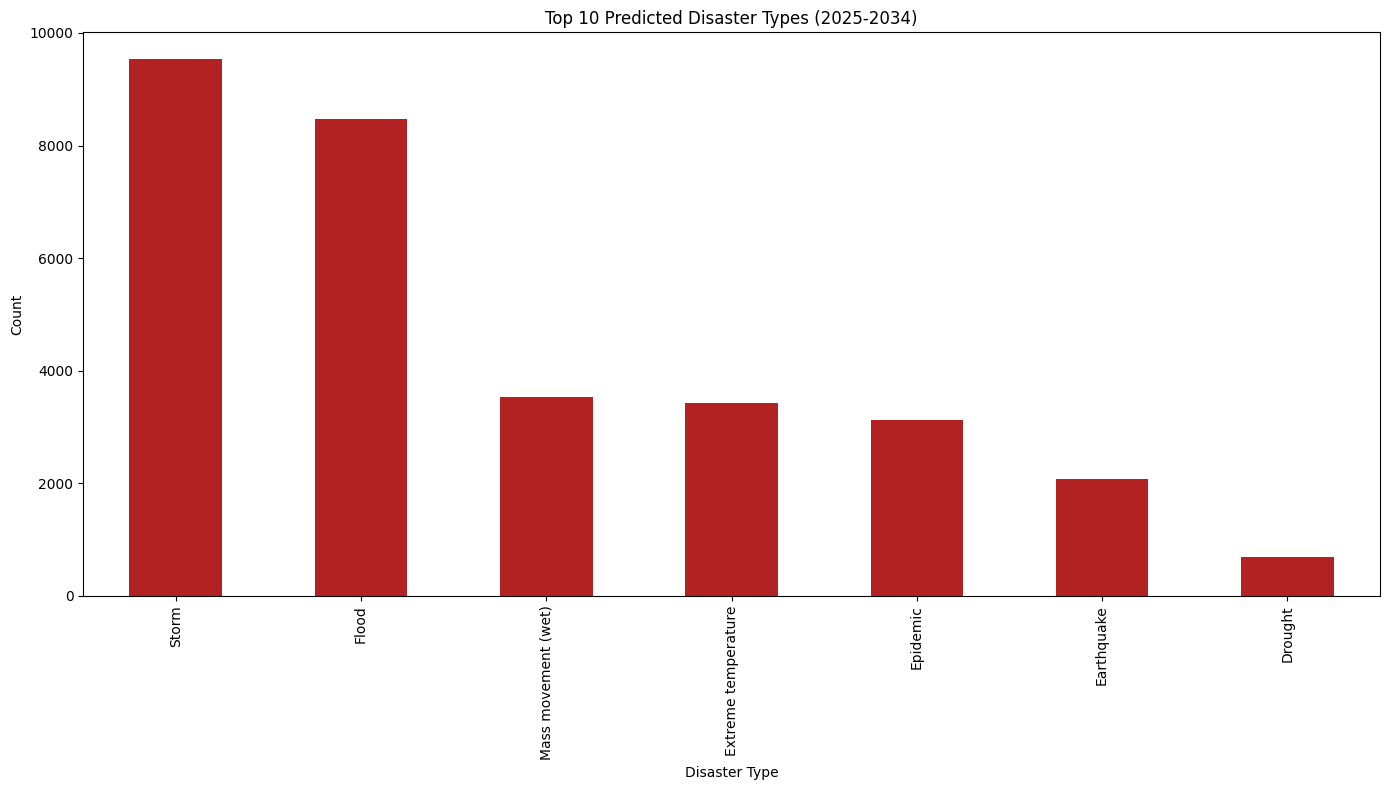

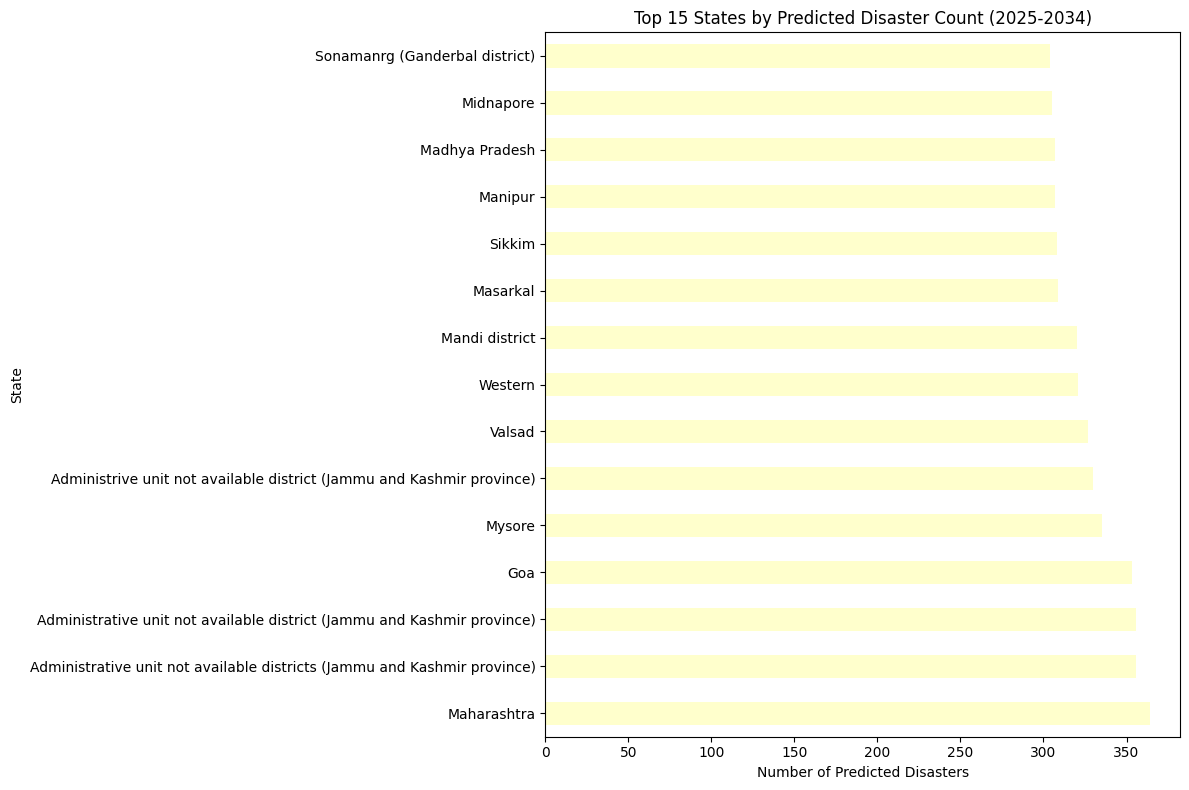

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import calendar
from sklearn.metrics import classification_report
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('disasterIND.csv', sep=',')

# Step 1: Data Exploration and Cleaning
print("Original dataset shape:", df.shape)

# Convert date columns to datetime
date_columns = ['Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create a start date column
df['Start_Date'] = pd.to_datetime(
    dict(year=df['Start Year'], month=df['Start Month'], day=df['Start Day']),
    errors='coerce'
)

# Create a simplified month column 
df['Month'] = pd.to_numeric(df['Start Month'], errors='coerce').fillna(1).astype(int)

# Create season column
def get_season(month):
    if pd.isna(month) or month == 0:
        return 'Unknown'
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Autumn'

# Apply the function to create season
df['Season'] = df['Month'].apply(get_season)

# Handle missing values for key columns
for col in ['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Location']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Step 2: Enhanced Feature Engineering
# Extract state from location
def extract_state(location_str):
    if pd.isna(location_str):
        return 'Unknown'
    
    states = [
        'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'Goa', 'Gujarat', 
        'Haryana', 'Himachal Pradesh', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 
        'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 
        'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Delhi',
        'Bengal'
    ]
    
    for state in states:
        if state.lower() in location_str.lower():
            return state
    
    return location_str.split(',')[0] if ',' in location_str else location_str

# Apply the state extraction
df['State'] = df['Location'].apply(extract_state)

# Create climate zone feature
def assign_climate_zone(state):
    # Define climate zones for Indian states
    tropical = ['Kerala', 'Tamil Nadu', 'Karnataka', 'Andhra Pradesh', 'Telangana', 'Goa']
    subtropical = ['Maharashtra', 'Madhya Pradesh', 'Chhattisgarh', 'Odisha', 'West Bengal', 'Bengal']
    arid = ['Rajasthan', 'Gujarat']
    semi_arid = ['Punjab', 'Haryana', 'Delhi', 'Uttar Pradesh']
    montane = ['Himachal Pradesh', 'Uttarakhand', 'Jammu and Kashmir', 'Sikkim', 'Arunachal Pradesh']
    humid_subtropical = ['Assam', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura', 'Bihar', 'Jharkhand']
    
    if state in tropical:
        return 'Tropical'
    elif state in subtropical:
        return 'Subtropical'
    elif state in arid:
        return 'Arid'
    elif state in semi_arid:
        return 'Semi-Arid'
    elif state in montane:
        return 'Montane'
    elif state in humid_subtropical:
        return 'Humid Subtropical'
    else:
        return 'Unknown'

df['Climate_Zone'] = df['State'].apply(assign_climate_zone)

# Create coastal state feature
coastal_states = ['Gujarat', 'Maharashtra', 'Goa', 'Karnataka', 'Kerala', 'Tamil Nadu', 
                  'Andhra Pradesh', 'Odisha', 'West Bengal', 'Bengal']
df['Is_Coastal'] = df['State'].apply(lambda x: 1 if x in coastal_states else 0)

# Create geographical region feature
def assign_region(state):
    north = ['Jammu and Kashmir', 'Himachal Pradesh', 'Punjab', 'Haryana', 'Uttarakhand', 'Delhi']
    central = ['Rajasthan', 'Uttar Pradesh', 'Madhya Pradesh', 'Chhattisgarh']
    east = ['Bihar', 'Jharkhand', 'West Bengal', 'Bengal', 'Odisha']
    northeast = ['Sikkim', 'Assam', 'Arunachal Pradesh', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura']
    west = ['Gujarat', 'Maharashtra', 'Goa']
    south = ['Karnataka', 'Telangana', 'Andhra Pradesh', 'Tamil Nadu', 'Kerala']
    
    if state in north:
        return 'North'
    elif state in central:
        return 'Central'
    elif state in east:
        return 'East'
    elif state in northeast:
        return 'Northeast'
    elif state in west:
        return 'West'
    elif state in south:
        return 'South'
    else:
        return 'Unknown'

df['Region'] = df['State'].apply(assign_region)

# Create severity indicator based on deaths and affected
df['Total Deaths'] = pd.to_numeric(df['Total Deaths'], errors='coerce').fillna(0)
df['Total Affected'] = pd.to_numeric(df['Total Affected'], errors='coerce').fillna(0)
df['Severity'] = np.log1p(df['Total Deaths'] + 0.1*df['Total Affected'])

# Step 3: Calculate disaster frequencies and patterns
# Get disaster frequency by type, state, and month
disaster_type_freq = df.groupby('Disaster Type').size().to_dict()
state_disaster_freq = df.groupby(['State', 'Disaster Type']).size().unstack(fill_value=0)
month_disaster_freq = df.groupby(['Month', 'Disaster Type']).size().unstack(fill_value=0)
season_disaster_freq = df.groupby(['Season', 'Disaster Type']).size().unstack(fill_value=0)
climate_disaster_freq = df.groupby(['Climate_Zone', 'Disaster Type']).size().unstack(fill_value=0)

# Calculate disaster periodicity
yearly_disasters = df.groupby(['Start Year', 'Disaster Type']).size().unstack(fill_value=0)
disaster_periodicity = {}

for disaster in df['Disaster Type'].unique():
    disaster_data = yearly_disasters.get(disaster, pd.Series())
    if not disaster_data.empty:
        # Find years with disasters
        years_with_disasters = disaster_data[disaster_data > 0].index.tolist()
        if len(years_with_disasters) >= 2:
            # Calculate intervals between occurrences
            intervals = [years_with_disasters[i+1] - years_with_disasters[i] 
                        for i in range(len(years_with_disasters)-1)]
            if intervals:
                avg_interval = sum(intervals) / len(intervals)
                disaster_periodicity[disaster] = round(avg_interval, 1)

print("\nAverage years between disaster occurrences:")
for disaster, period in sorted(disaster_periodicity.items()):
    print(f"{disaster}: {period} years")

# Step 4: Prepare features for prediction models
# Define features to use
features = ['Month', 'Season', 'State', 'Climate_Zone', 'Region', 'Is_Coastal']
disaster_types = df['Disaster Type'].unique()

# Create a copy of the dataframe for processing
df_proc = df.copy()

# Encode categorical variables consistently
label_encoders = {}
for column in features:
    if column in df_proc.columns and df_proc[column].dtype == 'object':
        le = LabelEncoder()
        df_proc[column] = le.fit_transform(df_proc[column])
        label_encoders[column] = le
    elif column == 'Is_Coastal':  # Already numeric
        pass

# Get the feature matrix X
X = df_proc[features].copy()

# Step 5: Build prediction models for each disaster type
disaster_models = {}
disaster_classes = {}  # Store number of classes for each disaster type model

for disaster in disaster_types:
    # Create binary target: 1 if this disaster, 0 otherwise
    y_binary = (df['Disaster Type'] == disaster).astype(int)
    
    # Check if we have enough positive samples
    positive_samples = sum(y_binary)
    if positive_samples < 5:
        print(f"Warning: Not enough samples for {disaster} ({positive_samples} found). Skipping.")
        continue
    
    # Use consistent features
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.25, random_state=42)
    
    # Train a Random Forest model for this disaster type
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Store the model
    disaster_models[disaster] = rf_model
    
    # Store number of classes - important for prediction
    disaster_classes[disaster] = len(np.unique(y_train))
    
    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    print(f"\nClassification Report for {disaster}:")
    print(classification_report(y_test, y_pred))

# Step 6: Generate future predictions for 10 years (2025-2034)
# Create future years dataframe with exactly the same columns and transformations
future_years = range(2025, 2035)  # 10 years
months = range(1, 13)
states = df['State'].unique()

future_data = []
for year in future_years:
    for month in months:
        for state in states:
            future_data.append([year, month, state])

future_df = pd.DataFrame(future_data, columns=['Year', 'Month', 'State'])

# Add derived features using the same functions as before
future_df['Season'] = future_df['Month'].apply(get_season)
future_df['Climate_Zone'] = future_df['State'].apply(assign_climate_zone)
future_df['Is_Coastal'] = future_df['State'].apply(lambda x: 1 if x in coastal_states else 0)
future_df['Region'] = future_df['State'].apply(assign_region)

# Encode categorical features using the same encoders from training
future_df_encoded = future_df.copy()
for column in features:
    if column in label_encoders:  # For categorical columns
        # Map values not seen during training to a value that was seen
        future_df_encoded[column] = future_df[column].apply(
            lambda x: x if x in label_encoders[column].classes_ else label_encoders[column].classes_[0]
        )
        future_df_encoded[column] = label_encoders[column].transform(future_df_encoded[column])

# Ensure future_X has exactly the same columns as X, in the same order
future_X = future_df_encoded[features].copy()

# Step 7: Make predictions for each disaster type
for disaster, model in disaster_models.items():
    # Check how many classes this model has - fixes the IndexError
    num_classes = disaster_classes[disaster]
    
    # Get the probabilities
    probs = model.predict_proba(future_X)
    
    # If there's only one class (all negative), set probability to 0
    if num_classes == 1 or probs.shape[1] == 1:
        future_df[f"Prob_{disaster}"] = 0
    else:
        # Otherwise use the probability of the positive class (index 1)
        future_df[f"Prob_{disaster}"] = probs[:, 1]

# Step 8: Apply adjustments based on historical patterns
for idx, row in future_df.iterrows():
    month = row['Month']
    state = row['State']
    season = row['Season']
    climate = row['Climate_Zone']
    
    for disaster in disaster_models.keys():
        base_prob = row[f"Prob_{disaster}"]
        
        # Seasonal adjustment
        season_factor = 1.0
        if season in season_disaster_freq.index and disaster in season_disaster_freq.columns:
            if season_disaster_freq.loc[season, disaster] > 0:
                season_factor = 1.2
        
        # Monthly adjustment
        month_factor = 1.0
        if month in month_disaster_freq.index and disaster in month_disaster_freq.columns:
            if month_disaster_freq.loc[month, disaster] > 0:
                month_factor = 1.3
        
        # State history adjustment
        state_factor = 1.0
        if state in state_disaster_freq.index and disaster in state_disaster_freq.columns:
            if state_disaster_freq.loc[state, disaster] > 0:
                state_factor = 1.5
        
        # Climate zone adjustment
        climate_factor = 1.0
        if climate in climate_disaster_freq.index and disaster in climate_disaster_freq.columns:
            if climate_disaster_freq.loc[climate, disaster] > 0:
                climate_factor = 1.2
        
        # Apply periodicity factor if available
        periodicity_factor = 1.0
        if disaster in disaster_periodicity:
            period = disaster_periodicity[disaster]
            last_occurrence = df[df['Disaster Type'] == disaster]['Start Year'].max()
            if not pd.isna(last_occurrence):
                years_since_last = row['Year'] - last_occurrence
                # If we're close to a predicted recurrence
                if abs(years_since_last % period) <= 1:
                    periodicity_factor = 1.5
        
        # Calculate final adjusted probability
        adjusted_prob = base_prob * season_factor * month_factor * state_factor * climate_factor * periodicity_factor
        
        # Cap at 1.0
        future_df.loc[idx, f"Adj_Prob_{disaster}"] = min(1.0, adjusted_prob)

# Step 9: Format predictions for analysis
# Get all adjusted probability columns
adj_prob_cols = [col for col in future_df.columns if col.startswith('Adj_Prob_')]

# Find the most likely disaster type for each location and time
future_df['Most_Likely_Disaster'] = future_df[adj_prob_cols].idxmax(axis=1).str.replace('Adj_Prob_', '')
future_df['Max_Probability'] = future_df[adj_prob_cols].max(axis=1)

# Create a threshold for significant disaster probability
threshold = 0.3
significant_predictions = future_df[future_df['Max_Probability'] >= threshold].copy()

# Format month as name
significant_predictions['Month_Name'] = significant_predictions['Month'].apply(
    lambda x: calendar.month_name[int(x)]
)

# Step 10: Generate comprehensive prediction table
prediction_results = []

for idx, row in significant_predictions.iterrows():
    year = row['Year']
    month = row['Month_Name']
    state = row['State']
    
    # Get all disasters with significant probability
    for disaster in disaster_models.keys():
        prob = row[f"Adj_Prob_{disaster}"]
        if prob >= threshold:
            prediction_results.append({
                'Year': year,
                'Month': month,
                'State': state,
                'Disaster Type': disaster,
                'Probability': prob,
                'Climate Zone': row['Climate_Zone'],
                'Season': row['Season'],
                'Region': row['Region']
            })

# Convert to DataFrame and sort
prediction_df = pd.DataFrame(prediction_results)
if not prediction_df.empty:
    prediction_df = prediction_df.sort_values(by=['Year', 'Month', 'State', 'Probability'], ascending=[True, True, True, False])
    
    # Format probability as percentage
    prediction_df['Probability'] = prediction_df['Probability'].apply(lambda x: f"{x:.2%}")
    
    # Save the predictions to a CSV file
    prediction_df.to_csv('comprehensive_disaster_predictions_2025_2034.csv', index=False)
    
    print("\nComprehensive Disaster Predictions for 2025-2034:")
    print(prediction_df.head(20).to_string(index=False))
    
    # Step 11: Generate location-specific disaster profiles
    location_profiles = []
    
    for state in df['State'].unique():
        state_predictions = prediction_df[prediction_df['State'] == state]
        if not state_predictions.empty:
            disaster_counts = state_predictions['Disaster Type'].value_counts()
            
            profile = {
                'State': state,
                'Climate Zone': state_predictions['Climate Zone'].iloc[0],
                'Region': state_predictions['Region'].iloc[0],
                'Total Predicted Disasters': len(state_predictions),
                'Most Common Disaster': disaster_counts.index[0],
                'Most Common Disaster Count': disaster_counts.iloc[0],
                'All Potential Disasters': ', '.join(disaster_counts.index.tolist())
            }
            location_profiles.append(profile)
    
    location_profiles_df = pd.DataFrame(location_profiles)
    if not location_profiles_df.empty:
        location_profiles_df = location_profiles_df.sort_values('Total Predicted Disasters', ascending=False)
        location_profiles_df.to_csv('location_disaster_profiles_2025_2034.csv', index=False)
        
        print("\nLocation-Specific Disaster Profiles (Top 10):")
        print(location_profiles_df.head(10).to_string(index=False))
    
    # Step 12: Generate yearly disaster summary
    yearly_summary = prediction_df.groupby(['Year', 'Disaster Type']).size().unstack(fill_value=0)
    yearly_summary.to_csv('yearly_disaster_summary_2025_2034.csv')
    
    print("\nYearly Disaster Summary (2025-2034):")
    print(yearly_summary.to_string())
    
    # Step 13: Visualize key findings
    try:
        plt.figure(figsize=(14, 8))
        disaster_counts = prediction_df['Disaster Type'].value_counts().head(10)
        disaster_counts.plot(kind='bar', color='firebrick')
        plt.title('Top 10 Predicted Disaster Types (2025-2034)')
        plt.xlabel('Disaster Type')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig('top_predicted_disasters.png')
        
        # Map of disaster hotspots
        plt.figure(figsize=(12, 8))
        state_counts = prediction_df['State'].value_counts().head(15)
        state_counts.plot(kind='barh', cmap='YlOrRd')
        plt.title('Top 15 States by Predicted Disaster Count (2025-2034)')
        plt.xlabel('Number of Predicted Disasters')
        plt.tight_layout()
        plt.savefig('state_disaster_predictions.png')
    except Exception as e:
        print(f"Warning: Could not generate some visualizations: {e}")
    
    print("\nAnalysis complete! Output files have been saved.")
else:
    print("\nNo significant disaster predictions were found for 2025-2034.")

Original dataset shape: (783, 46)

Average years between disaster occurrences:
Drought: 8.4 years
Earthquake: 5.0 years
Epidemic: 3.9 years
Extreme temperature: 1.7 years
Flood: 1.5 years
Glacial lake outburst flood: 2.0 years
Mass movement (dry): 23.0 years
Mass movement (wet): 2.2 years
Storm: 1.4 years
Wildfire: 11.3 years

Classification Report for Drought:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       192
           1       0.00      0.00      0.00         4

    accuracy                           0.97       196
   macro avg       0.49      0.49      0.49       196
weighted avg       0.96      0.97      0.96       196


Classification Report for Earthquake:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       188
           1       0.00      0.00      0.00         8

    accuracy                           0.95       196
   macro avg       0.48      0.50      0.49       19

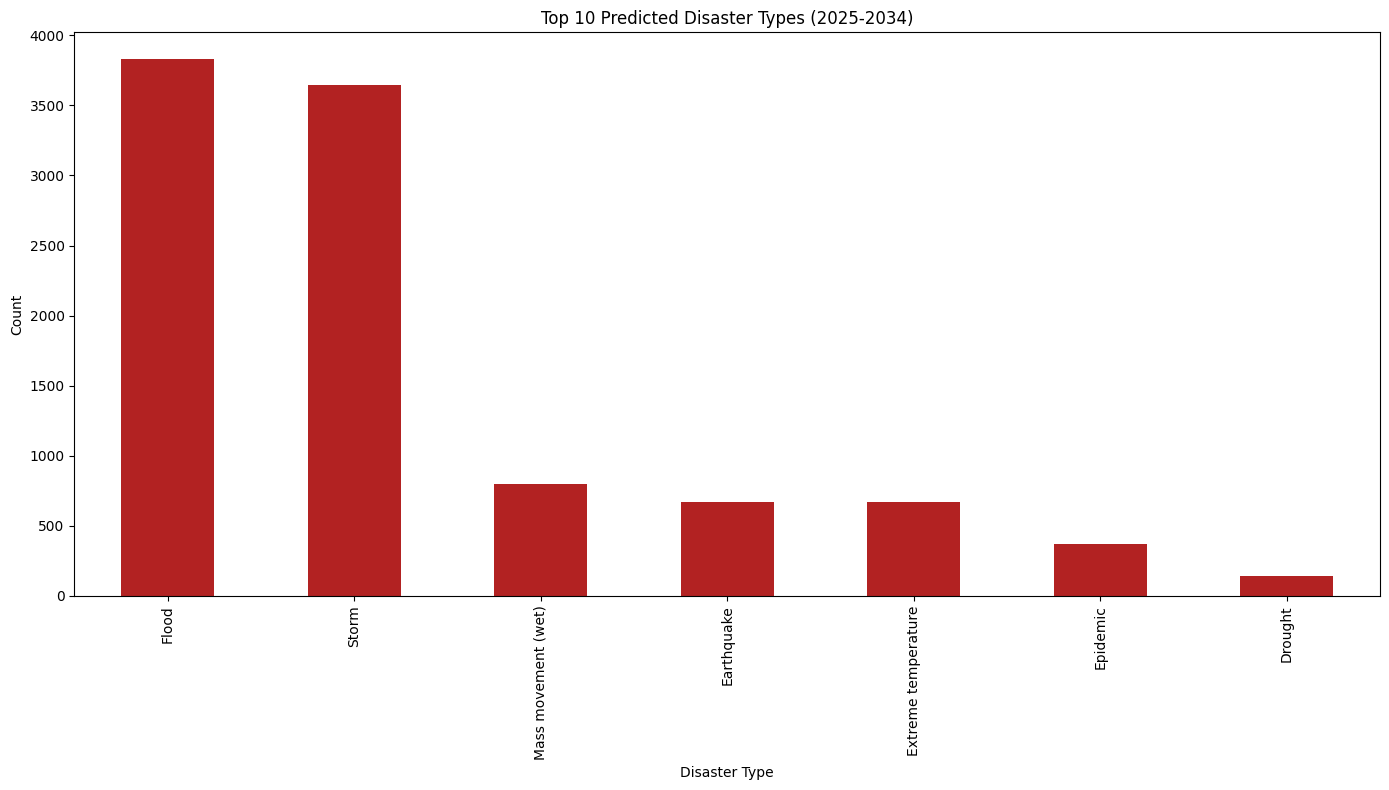

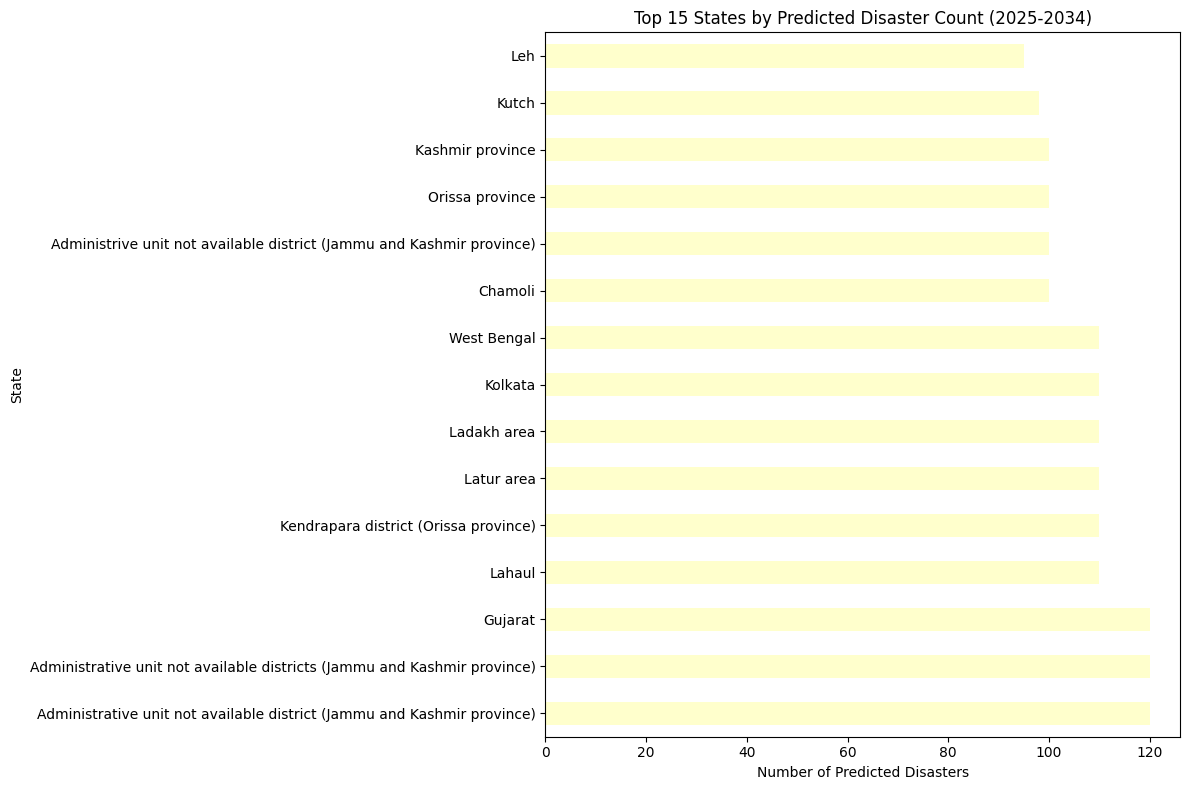

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import calendar
from sklearn.metrics import classification_report
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('disasterIND.csv', sep=',')

# Step 1: Data Exploration and Cleaning
print("Original dataset shape:", df.shape)

# Convert date columns to datetime
date_columns = ['Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create a start date column
df['Start_Date'] = pd.to_datetime(
    dict(year=df['Start Year'], month=df['Start Month'], day=df['Start Day']),
    errors='coerce'
)

# Create a simplified month column 
df['Month'] = pd.to_numeric(df['Start Month'], errors='coerce').fillna(1).astype(int)

# Create season column
def get_season(month):
    if pd.isna(month) or month == 0:
        return 'Unknown'
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Autumn'

# Apply the function to create season
df['Season'] = df['Month'].apply(get_season)

# Handle missing values for key columns
for col in ['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Location']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Step 2: Enhanced Feature Engineering
# Extract state from location
def extract_state(location_str):
    if pd.isna(location_str):
        return 'Unknown'
    
    states = [
        'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'Goa', 'Gujarat', 
        'Haryana', 'Himachal Pradesh', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 
        'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 
        'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Delhi',
        'Bengal'
    ]
    
    for state in states:
        if state.lower() in location_str.lower():
            return state
    
    return location_str.split(',')[0] if ',' in location_str else location_str

# Apply the state extraction
df['State'] = df['Location'].apply(extract_state)

# Create climate zone feature
def assign_climate_zone(state):
    # Define climate zones for Indian states
    tropical = ['Kerala', 'Tamil Nadu', 'Karnataka', 'Andhra Pradesh', 'Telangana', 'Goa']
    subtropical = ['Maharashtra', 'Madhya Pradesh', 'Chhattisgarh', 'Odisha', 'West Bengal', 'Bengal']
    arid = ['Rajasthan', 'Gujarat']
    semi_arid = ['Punjab', 'Haryana', 'Delhi', 'Uttar Pradesh']
    montane = ['Himachal Pradesh', 'Uttarakhand', 'Jammu and Kashmir', 'Sikkim', 'Arunachal Pradesh']
    humid_subtropical = ['Assam', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura', 'Bihar', 'Jharkhand']
    
    if state in tropical:
        return 'Tropical'
    elif state in subtropical:
        return 'Subtropical'
    elif state in arid:
        return 'Arid'
    elif state in semi_arid:
        return 'Semi-Arid'
    elif state in montane:
        return 'Montane'
    elif state in humid_subtropical:
        return 'Humid Subtropical'
    else:
        return 'Unknown'

df['Climate_Zone'] = df['State'].apply(assign_climate_zone)

# Create coastal state feature
coastal_states = ['Gujarat', 'Maharashtra', 'Goa', 'Karnataka', 'Kerala', 'Tamil Nadu', 
                  'Andhra Pradesh', 'Odisha', 'West Bengal', 'Bengal']
df['Is_Coastal'] = df['State'].apply(lambda x: 1 if x in coastal_states else 0)

# Create geographical region feature
def assign_region(state):
    north = ['Jammu and Kashmir', 'Himachal Pradesh', 'Punjab', 'Haryana', 'Uttarakhand', 'Delhi']
    central = ['Rajasthan', 'Uttar Pradesh', 'Madhya Pradesh', 'Chhattisgarh']
    east = ['Bihar', 'Jharkhand', 'West Bengal', 'Bengal', 'Odisha']
    northeast = ['Sikkim', 'Assam', 'Arunachal Pradesh', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura']
    west = ['Gujarat', 'Maharashtra', 'Goa']
    south = ['Karnataka', 'Telangana', 'Andhra Pradesh', 'Tamil Nadu', 'Kerala']
    
    if state in north:
        return 'North'
    elif state in central:
        return 'Central'
    elif state in east:
        return 'East'
    elif state in northeast:
        return 'Northeast'
    elif state in west:
        return 'West'
    elif state in south:
        return 'South'
    else:
        return 'Unknown'

df['Region'] = df['State'].apply(assign_region)

# Create severity indicator based on deaths and affected
df['Total Deaths'] = pd.to_numeric(df['Total Deaths'], errors='coerce').fillna(0)
df['Total Affected'] = pd.to_numeric(df['Total Affected'], errors='coerce').fillna(0)
df['Severity'] = np.log1p(df['Total Deaths'] + 0.1*df['Total Affected'])

# Step 3: Calculate disaster frequencies and patterns
# Get disaster frequency by type, state, and month
disaster_type_freq = df.groupby('Disaster Type').size().to_dict()
state_disaster_freq = df.groupby(['State', 'Disaster Type']).size().unstack(fill_value=0)
month_disaster_freq = df.groupby(['Month', 'Disaster Type']).size().unstack(fill_value=0)
season_disaster_freq = df.groupby(['Season', 'Disaster Type']).size().unstack(fill_value=0)
climate_disaster_freq = df.groupby(['Climate_Zone', 'Disaster Type']).size().unstack(fill_value=0)

# Calculate disaster periodicity
yearly_disasters = df.groupby(['Start Year', 'Disaster Type']).size().unstack(fill_value=0)
disaster_periodicity = {}

for disaster in df['Disaster Type'].unique():
    disaster_data = yearly_disasters.get(disaster, pd.Series())
    if not disaster_data.empty:
        # Find years with disasters
        years_with_disasters = disaster_data[disaster_data > 0].index.tolist()
        if len(years_with_disasters) >= 2:
            # Calculate intervals between occurrences
            intervals = [years_with_disasters[i+1] - years_with_disasters[i] 
                        for i in range(len(years_with_disasters)-1)]
            if intervals:
                avg_interval = sum(intervals) / len(intervals)
                disaster_periodicity[disaster] = round(avg_interval, 1)

print("\nAverage years between disaster occurrences:")
for disaster, period in sorted(disaster_periodicity.items()):
    print(f"{disaster}: {period} years")

# Step 4: Prepare features for prediction models
# Define features to use
features = ['Month', 'Season', 'State', 'Climate_Zone', 'Region', 'Is_Coastal']
disaster_types = df['Disaster Type'].unique()

# Create a copy of the dataframe for processing
df_proc = df.copy()

# Encode categorical variables consistently
label_encoders = {}
for column in features:
    if column in df_proc.columns and df_proc[column].dtype == 'object':
        le = LabelEncoder()
        df_proc[column] = le.fit_transform(df_proc[column])
        label_encoders[column] = le
    elif column == 'Is_Coastal':  # Already numeric
        pass

# Get the feature matrix X
X = df_proc[features].copy()

# Step 5: Build prediction models for each disaster type
disaster_models = {}
disaster_classes = {}  # Store number of classes for each disaster type model

for disaster in disaster_types:
    # Create binary target: 1 if this disaster, 0 otherwise
    y_binary = (df['Disaster Type'] == disaster).astype(int)
    
    # Check if we have enough positive samples
    positive_samples = sum(y_binary)
    if positive_samples < 5:
        print(f"Warning: Not enough samples for {disaster} ({positive_samples} found). Skipping.")
        continue
    
    # Use consistent features
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.25, random_state=42)
    
    # Train a Random Forest model for this disaster type
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Store the model
    disaster_models[disaster] = rf_model
    
    # Store number of classes - important for prediction
    disaster_classes[disaster] = len(np.unique(y_train))
    
    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    print(f"\nClassification Report for {disaster}:")
    print(classification_report(y_test, y_pred))

# Step 6: Generate future predictions for 10 years (2025-2034)
# Create future years dataframe with exactly the same columns and transformations
future_years = range(2025, 2035)  # 10 years
months = range(1, 13)
states = df['State'].unique()

future_data = []
for year in future_years:
    for month in months:
        for state in states:
            future_data.append([year, month, state])

future_df = pd.DataFrame(future_data, columns=['Year', 'Month', 'State'])

# Add derived features using the same functions as before
future_df['Season'] = future_df['Month'].apply(get_season)
future_df['Climate_Zone'] = future_df['State'].apply(assign_climate_zone)
future_df['Is_Coastal'] = future_df['State'].apply(lambda x: 1 if x in coastal_states else 0)
future_df['Region'] = future_df['State'].apply(assign_region)

# Encode categorical features using the same encoders from training
future_df_encoded = future_df.copy()
for column in features:
    if column in label_encoders:  # For categorical columns
        # Map values not seen during training to a value that was seen
        future_df_encoded[column] = future_df[column].apply(
            lambda x: x if x in label_encoders[column].classes_ else label_encoders[column].classes_[0]
        )
        future_df_encoded[column] = label_encoders[column].transform(future_df_encoded[column])

# Ensure future_X has exactly the same columns as X, in the same order
future_X = future_df_encoded[features].copy()

# Step 7: Make predictions for each disaster type
for disaster, model in disaster_models.items():
    # Check how many classes this model has - fixes the IndexError
    num_classes = disaster_classes[disaster]
    
    # Get the probabilities
    probs = model.predict_proba(future_X)
    
    # If there's only one class (all negative), set probability to 0
    if num_classes == 1 or probs.shape[1] == 1:
        future_df[f"Prob_{disaster}"] = 0
    else:
        # Otherwise use the probability of the positive class (index 1)
        future_df[f"Prob_{disaster}"] = probs[:, 1]

# Step 8: Apply adjustments based on historical patterns using a weighted average approach
# Define weights for different factors
weights = {
    'base': 0.5,      # Base probability from the model
    'season': 0.1,    # Seasonal influence
    'month': 0.1,     # Monthly influence
    'state': 0.15,    # State historical influence
    'climate': 0.05,  # Climate zone influence
    'periodicity': 0.1 # Cyclical pattern influence
}

for idx, row in future_df.iterrows():
    month = row['Month']
    state = row['State']
    season = row['Season']
    climate = row['Climate_Zone']
    
    for disaster in disaster_models.keys():
        base_prob = row[f"Prob_{disaster}"]
        
        # Calculate adjustment factors (smaller values than before)
        season_factor = 1.0
        if season in season_disaster_freq.index and disaster in season_disaster_freq.columns:
            if season_disaster_freq.loc[season, disaster] > 0:
                season_factor = 1.1  # Reduced from 1.2
        
        month_factor = 1.0
        if month in month_disaster_freq.index and disaster in month_disaster_freq.columns:
            if month_disaster_freq.loc[month, disaster] > 0:
                month_factor = 1.1  # Reduced from 1.3
        
        state_factor = 1.0
        if state in state_disaster_freq.index and disaster in state_disaster_freq.columns:
            if state_disaster_freq.loc[state, disaster] > 0:
                state_factor = 1.2  # Reduced from 1.5
        
        climate_factor = 1.0
        if climate in climate_disaster_freq.index and disaster in climate_disaster_freq.columns:
            if climate_disaster_freq.loc[climate, disaster] > 0:
                climate_factor = 1.05  # Reduced from 1.2
        
        periodicity_factor = 1.0
        if disaster in disaster_periodicity:
            period = disaster_periodicity[disaster]
            last_occurrence = df[df['Disaster Type'] == disaster]['Start Year'].max()
            if not pd.isna(last_occurrence):
                years_since_last = row['Year'] - last_occurrence
                # If we're close to a predicted recurrence
                if abs(years_since_last % period) <= 1:
                    periodicity_factor = 1.15  # Reduced from 1.5
        
        # Calculate final adjusted probability using weighted average
        weighted_prob = (
            base_prob * weights['base'] +
            (base_prob * season_factor - base_prob) * weights['season'] +
            (base_prob * month_factor - base_prob) * weights['month'] +
            (base_prob * state_factor - base_prob) * weights['state'] +
            (base_prob * climate_factor - base_prob) * weights['climate'] +
            (base_prob * periodicity_factor - base_prob) * weights['periodicity']
        )
        
        # Cap at 1.0
        future_df.loc[idx, f"Adj_Prob_{disaster}"] = min(0.95, weighted_prob)  # Cap at 0.95 instead of 1.0

# Step 9: Format predictions for analysis
# Get all adjusted probability columns
adj_prob_cols = [col for col in future_df.columns if col.startswith('Adj_Prob_')]

# Find the most likely disaster type for each location and time
future_df['Most_Likely_Disaster'] = future_df[adj_prob_cols].idxmax(axis=1).str.replace('Adj_Prob_', '')
future_df['Max_Probability'] = future_df[adj_prob_cols].max(axis=1)

# Create a threshold for significant disaster probability
threshold = 0.3
significant_predictions = future_df[future_df['Max_Probability'] >= threshold].copy()

# Format month as name
significant_predictions['Month_Name'] = significant_predictions['Month'].apply(
    lambda x: calendar.month_name[int(x)]
)

# Step 10: Generate comprehensive prediction table
prediction_results = []

for idx, row in significant_predictions.iterrows():
    year = row['Year']
    month = row['Month_Name']
    state = row['State']
    
    # Get all disasters with significant probability
    for disaster in disaster_models.keys():
        prob = row[f"Adj_Prob_{disaster}"]
        if prob >= threshold:
            prediction_results.append({
                'Year': year,
                'Month': month,
                'State': state,
                'Disaster Type': disaster,
                'Probability': prob,
                'Climate Zone': row['Climate_Zone'],
                'Season': row['Season'],
                'Region': row['Region']
            })

# Convert to DataFrame and sort
prediction_df = pd.DataFrame(prediction_results)
if not prediction_df.empty:
    prediction_df = prediction_df.sort_values(by=['Year', 'Month', 'State', 'Probability'], ascending=[True, True, True, False])
    
    # Format probability as percentage
    prediction_df['Probability'] = prediction_df['Probability'].apply(lambda x: f"{x:.2%}")
    
    # Save the predictions to a CSV file
    prediction_df.to_csv('comprehensive_disaster_predictions_2025_2034.csv', index=False)
    
    print("\nComprehensive Disaster Predictions for 2025-2034:")
    print(prediction_df.head(20).to_string(index=False))
    
    # Step 11: Generate location-specific disaster profiles
    location_profiles = []
    
    for state in df['State'].unique():
        state_predictions = prediction_df[prediction_df['State'] == state]
        if not state_predictions.empty:
            disaster_counts = state_predictions['Disaster Type'].value_counts()
            
            profile = {
                'State': state,
                'Climate Zone': state_predictions['Climate Zone'].iloc[0],
                'Region': state_predictions['Region'].iloc[0],
                'Total Predicted Disasters': len(state_predictions),
                'Most Common Disaster': disaster_counts.index[0],
                'Most Common Disaster Count': disaster_counts.iloc[0],
                'All Potential Disasters': ', '.join(disaster_counts.index.tolist())
            }
            location_profiles.append(profile)
    
    location_profiles_df = pd.DataFrame(location_profiles)
    if not location_profiles_df.empty:
        location_profiles_df = location_profiles_df.sort_values('Total Predicted Disasters', ascending=False)
        location_profiles_df.to_csv('location_disaster_profiles_2025_2034.csv', index=False)
        
        print("\nLocation-Specific Disaster Profiles (Top 10):")
        print(location_profiles_df.head(10).to_string(index=False))
    
    # Step 12: Generate yearly disaster summary
    yearly_summary = prediction_df.groupby(['Year', 'Disaster Type']).size().unstack(fill_value=0)
    yearly_summary.to_csv('yearly_disaster_summary_2025_2034.csv')
    
    print("\nYearly Disaster Summary (2025-2034):")
    print(yearly_summary.to_string())
    
    # Step 13: Visualize key findings
    try:
        plt.figure(figsize=(14, 8))
        disaster_counts = prediction_df['Disaster Type'].value_counts().head(10)
        disaster_counts.plot(kind='bar', color='firebrick')
        plt.title('Top 10 Predicted Disaster Types (2025-2034)')
        plt.xlabel('Disaster Type')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig('top_predicted_disasters.png')
        
        # Map of disaster hotspots
        plt.figure(figsize=(12, 8))
        state_counts = prediction_df['State'].value_counts().head(15)
        state_counts.plot(kind='barh', cmap='YlOrRd')
        plt.title('Top 15 States by Predicted Disaster Count (2025-2034)')
        plt.xlabel('Number of Predicted Disasters')
        plt.tight_layout()
        plt.savefig('state_disaster_predictions.png')
    except Exception as e:
        print(f"Warning: Could not generate some visualizations: {e}")
    
    print("\nAnalysis complete! Output files have been saved.")
else:
    print("\nNo significant disaster predictions were found for 2025-2034.")

NEW TRY

Original dataset shape: (783, 46)

Average years between disaster occurrences:
Drought: 8.4 years
Earthquake: 5.0 years
Epidemic: 3.9 years
Extreme temperature: 1.7 years
Flood: 1.5 years
Glacial lake outburst flood: 2.0 years
Mass movement (dry): 23.0 years
Mass movement (wet): 2.2 years
Storm: 1.4 years
Wildfire: 11.3 years

Classification Report for Drought:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       192
           1       0.00      0.00      0.00         4

    accuracy                           0.97       196
   macro avg       0.49      0.49      0.49       196
weighted avg       0.96      0.97      0.96       196


Classification Report for Earthquake:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       188
           1       0.00      0.00      0.00         8

    accuracy                           0.95       196
   macro avg       0.48      0.50      0.49       19

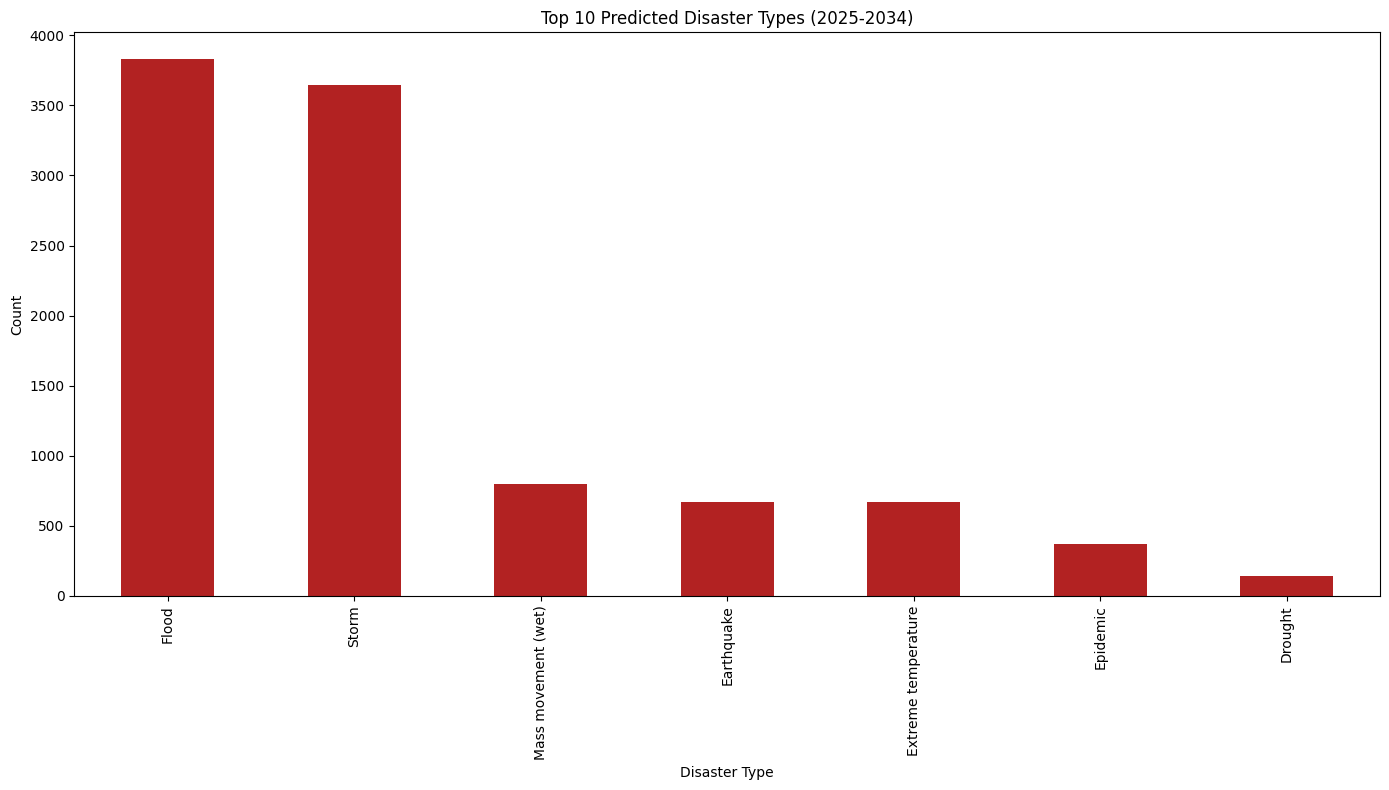

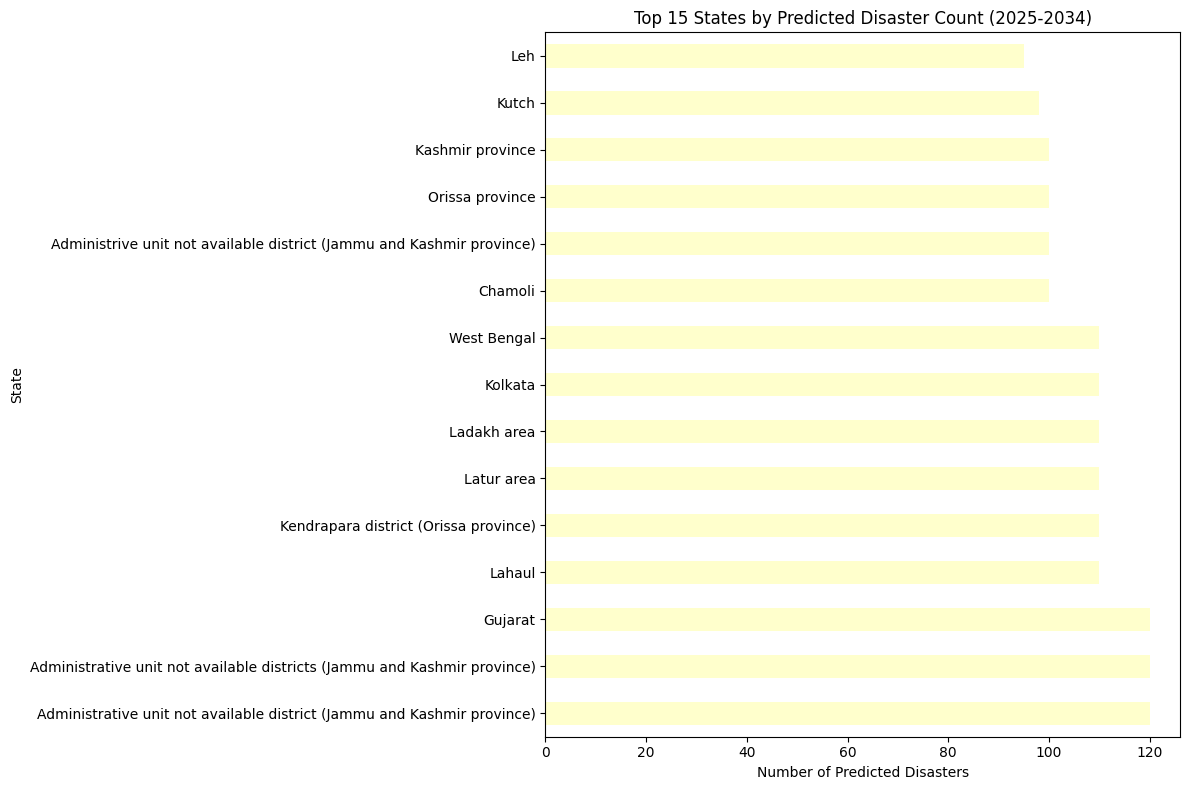

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import calendar
from sklearn.metrics import classification_report
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('disasterIND.csv', sep=',')

# Step 1: Data Exploration and Cleaning
print("Original dataset shape:", df.shape)

# Convert date columns to datetime
date_columns = ['Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create a start date column
df['Start_Date'] = pd.to_datetime(
    dict(year=df['Start Year'], month=df['Start Month'], day=df['Start Day']),
    errors='coerce'
)

# Create a simplified month column 
df['Month'] = pd.to_numeric(df['Start Month'], errors='coerce').fillna(1).astype(int)

# Create season column
def get_season(month):
    if pd.isna(month) or month == 0:
        return 'Unknown'
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Autumn'

# Apply the function to create season
df['Season'] = df['Month'].apply(get_season)

# Handle missing values for key columns
for col in ['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Location']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Step 2: Enhanced Feature Engineering
# Extract state from location
def extract_state(location_str):
    if pd.isna(location_str):
        return 'Unknown'
    
    states = [
        'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'Goa', 'Gujarat', 
        'Haryana', 'Himachal Pradesh', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 
        'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 
        'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Delhi',
        'Bengal'
    ]
    
    for state in states:
        if state.lower() in location_str.lower():
            return state
    
    return location_str.split(',')[0] if ',' in location_str else location_str

# Apply the state extraction
df['State'] = df['Location'].apply(extract_state)

# Create climate zone feature
def assign_climate_zone(state):
    # Define climate zones for Indian states
    tropical = ['Kerala', 'Tamil Nadu', 'Karnataka', 'Andhra Pradesh', 'Telangana', 'Goa']
    subtropical = ['Maharashtra', 'Madhya Pradesh', 'Chhattisgarh', 'Odisha', 'West Bengal', 'Bengal']
    arid = ['Rajasthan', 'Gujarat']
    semi_arid = ['Punjab', 'Haryana', 'Delhi', 'Uttar Pradesh']
    montane = ['Himachal Pradesh', 'Uttarakhand', 'Jammu and Kashmir', 'Sikkim', 'Arunachal Pradesh']
    humid_subtropical = ['Assam', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura', 'Bihar', 'Jharkhand']
    
    if state in tropical:
        return 'Tropical'
    elif state in subtropical:
        return 'Subtropical'
    elif state in arid:
        return 'Arid'
    elif state in semi_arid:
        return 'Semi-Arid'
    elif state in montane:
        return 'Montane'
    elif state in humid_subtropical:
        return 'Humid Subtropical'
    else:
        return 'Unknown'

df['Climate_Zone'] = df['State'].apply(assign_climate_zone)

# Create coastal state feature
coastal_states = ['Gujarat', 'Maharashtra', 'Goa', 'Karnataka', 'Kerala', 'Tamil Nadu', 
                  'Andhra Pradesh', 'Odisha', 'West Bengal', 'Bengal']
df['Is_Coastal'] = df['State'].apply(lambda x: 1 if x in coastal_states else 0)

# Create geographical region feature
def assign_region(state):
    north = ['Jammu and Kashmir', 'Himachal Pradesh', 'Punjab', 'Haryana', 'Uttarakhand', 'Delhi']
    central = ['Rajasthan', 'Uttar Pradesh', 'Madhya Pradesh', 'Chhattisgarh']
    east = ['Bihar', 'Jharkhand', 'West Bengal', 'Bengal', 'Odisha']
    northeast = ['Sikkim', 'Assam', 'Arunachal Pradesh', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura']
    west = ['Gujarat', 'Maharashtra', 'Goa']
    south = ['Karnataka', 'Telangana', 'Andhra Pradesh', 'Tamil Nadu', 'Kerala']
    
    if state in north:
        return 'North'
    elif state in central:
        return 'Central'
    elif state in east:
        return 'East'
    elif state in northeast:
        return 'Northeast'
    elif state in west:
        return 'West'
    elif state in south:
        return 'South'
    else:
        return 'Unknown'

df['Region'] = df['State'].apply(assign_region)

# Create severity indicator based on deaths and affected
df['Total Deaths'] = pd.to_numeric(df['Total Deaths'], errors='coerce').fillna(0)
df['Total Affected'] = pd.to_numeric(df['Total Affected'], errors='coerce').fillna(0)
df['Severity'] = np.log1p(df['Total Deaths'] + 0.1*df['Total Affected'])

# Step 3: Calculate disaster frequencies and patterns
# Get disaster frequency by type, state, and month
disaster_type_freq = df.groupby('Disaster Type').size().to_dict()
state_disaster_freq = df.groupby(['State', 'Disaster Type']).size().unstack(fill_value=0)
month_disaster_freq = df.groupby(['Month', 'Disaster Type']).size().unstack(fill_value=0)
season_disaster_freq = df.groupby(['Season', 'Disaster Type']).size().unstack(fill_value=0)
climate_disaster_freq = df.groupby(['Climate_Zone', 'Disaster Type']).size().unstack(fill_value=0)

# Calculate disaster periodicity
yearly_disasters = df.groupby(['Start Year', 'Disaster Type']).size().unstack(fill_value=0)
disaster_periodicity = {}

for disaster in df['Disaster Type'].unique():
    disaster_data = yearly_disasters.get(disaster, pd.Series())
    if not disaster_data.empty:
        # Find years with disasters
        years_with_disasters = disaster_data[disaster_data > 0].index.tolist()
        if len(years_with_disasters) >= 2:
            # Calculate intervals between occurrences
            intervals = [years_with_disasters[i+1] - years_with_disasters[i] 
                        for i in range(len(years_with_disasters)-1)]
            if intervals:
                avg_interval = sum(intervals) / len(intervals)
                disaster_periodicity[disaster] = round(avg_interval, 1)

print("\nAverage years between disaster occurrences:")
for disaster, period in sorted(disaster_periodicity.items()):
    print(f"{disaster}: {period} years")

# Step 4: Prepare features for prediction models
# Define features to use
features = ['Month', 'Season', 'State', 'Climate_Zone', 'Region', 'Is_Coastal']
disaster_types = df['Disaster Type'].unique()

# Create a copy of the dataframe for processing
df_proc = df.copy()

# Encode categorical variables consistently
label_encoders = {}
for column in features:
    if column in df_proc.columns and df_proc[column].dtype == 'object':
        le = LabelEncoder()
        df_proc[column] = le.fit_transform(df_proc[column])
        label_encoders[column] = le
    elif column == 'Is_Coastal':  # Already numeric
        pass

# Get the feature matrix X
X = df_proc[features].copy()

# Step 5: Build prediction models for each disaster type
disaster_models = {}
disaster_classes = {}  # Store number of classes for each disaster type model

for disaster in disaster_types:
    # Create binary target: 1 if this disaster, 0 otherwise
    y_binary = (df['Disaster Type'] == disaster).astype(int)
    
    # Check if we have enough positive samples
    positive_samples = sum(y_binary)
    if positive_samples < 5:
        print(f"Warning: Not enough samples for {disaster} ({positive_samples} found). Skipping.")
        continue
    
    # Use consistent features
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.25, random_state=42)
    
    # Train a Random Forest model for this disaster type
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Store the model
    disaster_models[disaster] = rf_model
    
    # Store number of classes - important for prediction
    disaster_classes[disaster] = len(np.unique(y_train))
    
    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    print(f"\nClassification Report for {disaster}:")
    print(classification_report(y_test, y_pred))

# Step 6: Generate future predictions for 10 years (2025-2034)
# Create future years dataframe with exactly the same columns and transformations
future_years = range(2025, 2035)  # 10 years
months = range(1, 13)
states = df['State'].unique()

future_data = []
for year in future_years:
    for month in months:
        for state in states:
            future_data.append([year, month, state])

future_df = pd.DataFrame(future_data, columns=['Year', 'Month', 'State'])

# Add derived features using the same functions as before
future_df['Season'] = future_df['Month'].apply(get_season)
future_df['Climate_Zone'] = future_df['State'].apply(assign_climate_zone)
future_df['Is_Coastal'] = future_df['State'].apply(lambda x: 1 if x in coastal_states else 0)
future_df['Region'] = future_df['State'].apply(assign_region)

# Encode categorical features using the same encoders from training
future_df_encoded = future_df.copy()
for column in features:
    if column in label_encoders:  # For categorical columns
        # Map values not seen during training to a value that was seen
        future_df_encoded[column] = future_df[column].apply(
            lambda x: x if x in label_encoders[column].classes_ else label_encoders[column].classes_[0]
        )
        future_df_encoded[column] = label_encoders[column].transform(future_df_encoded[column])

# Ensure future_X has exactly the same columns as X, in the same order
future_X = future_df_encoded[features].copy()

# Step 7: Make predictions for each disaster type
for disaster, model in disaster_models.items():
    # Check how many classes this model has - fixes the IndexError
    num_classes = disaster_classes[disaster]
    
    # Get the probabilities
    probs = model.predict_proba(future_X)
    
    # If there's only one class (all negative), set probability to 0
    if num_classes == 1 or probs.shape[1] == 1:
        future_df[f"Prob_{disaster}"] = 0
    else:
        # Otherwise use the probability of the positive class (index 1)
        future_df[f"Prob_{disaster}"] = probs[:, 1]

# Step 8: Apply adjustments based on historical patterns using a weighted average approach
# Define weights for different factors
weights = {
    'base': 0.5,      # Base probability from the model
    'season': 0.1,    # Seasonal influence
    'month': 0.1,     # Monthly influence
    'state': 0.15,    # State historical influence
    'climate': 0.05,  # Climate zone influence
    'periodicity': 0.1 # Cyclical pattern influence
}

for idx, row in future_df.iterrows():
    month = row['Month']
    state = row['State']
    season = row['Season']
    climate = row['Climate_Zone']
    
    for disaster in disaster_models.keys():
        base_prob = row[f"Prob_{disaster}"]
        
        # Calculate adjustment factors (smaller values than before)
        season_factor = 1.0
        if season in season_disaster_freq.index and disaster in season_disaster_freq.columns:
            if season_disaster_freq.loc[season, disaster] > 0:
                season_factor = 1.1  # Reduced from 1.2
        
        month_factor = 1.0
        if month in month_disaster_freq.index and disaster in month_disaster_freq.columns:
            if month_disaster_freq.loc[month, disaster] > 0:
                month_factor = 1.1  # Reduced from 1.3
        
        state_factor = 1.0
        if state in state_disaster_freq.index and disaster in state_disaster_freq.columns:
            if state_disaster_freq.loc[state, disaster] > 0:
                state_factor = 1.2  # Reduced from 1.5
        
        climate_factor = 1.0
        if climate in climate_disaster_freq.index and disaster in climate_disaster_freq.columns:
            if climate_disaster_freq.loc[climate, disaster] > 0:
                climate_factor = 1.05  # Reduced from 1.2
        
        periodicity_factor = 1.0
        if disaster in disaster_periodicity:
            period = disaster_periodicity[disaster]
            last_occurrence = df[df['Disaster Type'] == disaster]['Start Year'].max()
            if not pd.isna(last_occurrence):
                years_since_last = row['Year'] - last_occurrence
                # If we're close to a predicted recurrence
                if abs(years_since_last % period) <= 1:
                    periodicity_factor = 1.15  # Reduced from 1.5
        
        # Calculate final adjusted probability using weighted average
        weighted_prob = (
            base_prob * weights['base'] +
            (base_prob * season_factor - base_prob) * weights['season'] +
            (base_prob * month_factor - base_prob) * weights['month'] +
            (base_prob * state_factor - base_prob) * weights['state'] +
            (base_prob * climate_factor - base_prob) * weights['climate'] +
            (base_prob * periodicity_factor - base_prob) * weights['periodicity']
        )
        
        # Cap at 1.0
        future_df.loc[idx, f"Adj_Prob_{disaster}"] = min(0.95, weighted_prob)  # Cap at 0.95 instead of 1.0

# Step 9: Format predictions for analysis
# Get all adjusted probability columns
adj_prob_cols = [col for col in future_df.columns if col.startswith('Adj_Prob_')]

# Find the most likely disaster type for each location and time
future_df['Most_Likely_Disaster'] = future_df[adj_prob_cols].idxmax(axis=1).str.replace('Adj_Prob_', '')
future_df['Max_Probability'] = future_df[adj_prob_cols].max(axis=1)

# Create a threshold for significant disaster probability
threshold = 0.3
significant_predictions = future_df[future_df['Max_Probability'] >= threshold].copy()

# Format month as name
significant_predictions['Month_Name'] = significant_predictions['Month'].apply(
    lambda x: calendar.month_name[int(x)]
)

# Step 10: Generate comprehensive prediction table
prediction_results = []

for idx, row in significant_predictions.iterrows():
    year = row['Year']
    month = row['Month_Name']
    state = row['State']
    
    # Get all disasters with significant probability
    for disaster in disaster_models.keys():
        prob = row[f"Adj_Prob_{disaster}"]
        if prob >= threshold:
            prediction_results.append({
                'Year': year,
                'Month': month,
                'State': state,
                'Disaster Type': disaster,
                'Probability': prob,
                'Climate Zone': row['Climate_Zone'],
                'Season': row['Season'],
                'Region': row['Region']
            })

# Convert to DataFrame and sort
prediction_df = pd.DataFrame(prediction_results)
if not prediction_df.empty:
    prediction_df = prediction_df.sort_values(by=['Year', 'Month', 'State', 'Probability'], ascending=[True, True, True, False])
    
    # Format probability as percentage
    prediction_df['Probability'] = prediction_df['Probability'].apply(lambda x: f"{x:.2%}")
    
    # Save the predictions to a CSV file
    prediction_df.to_csv('comprehensive_disaster_predictions_2025_2034.csv', index=False)
    
    print("\nComprehensive Disaster Predictions for 2025-2034:")
    print(prediction_df.head(20).to_string(index=False))
    
    # Step 11: Generate location-specific disaster profiles
    location_profiles = []
    
    for state in df['State'].unique():
        state_predictions = prediction_df[prediction_df['State'] == state]
        if not state_predictions.empty:
            disaster_counts = state_predictions['Disaster Type'].value_counts()
            
            profile = {
                'State': state,
                'Climate Zone': state_predictions['Climate Zone'].iloc[0],
                'Region': state_predictions['Region'].iloc[0],
                'Total Predicted Disasters': len(state_predictions),
                'Most Common Disaster': disaster_counts.index[0],
                'Most Common Disaster Count': disaster_counts.iloc[0],
                'All Potential Disasters': ', '.join(disaster_counts.index.tolist())
            }
            location_profiles.append(profile)
    
    location_profiles_df = pd.DataFrame(location_profiles)
    if not location_profiles_df.empty:
        location_profiles_df = location_profiles_df.sort_values('Total Predicted Disasters', ascending=False)
        location_profiles_df.to_csv('location_disaster_profiles_2025_2034.csv', index=False)
        
        print("\nLocation-Specific Disaster Profiles (Top 10):")
        print(location_profiles_df.head(10).to_string(index=False))
    
    # Step 12: Generate yearly disaster summary
    yearly_summary = prediction_df.groupby(['Year', 'Disaster Type']).size().unstack(fill_value=0)
    yearly_summary.to_csv('yearly_disaster_summary_2025_2034.csv')
    
    print("\nYearly Disaster Summary (2025-2034):")
    print(yearly_summary.to_string())
    
    # Step 13: Visualize key findings
    try:
        plt.figure(figsize=(14, 8))
        disaster_counts = prediction_df['Disaster Type'].value_counts().head(10)
        disaster_counts.plot(kind='bar', color='firebrick')
        plt.title('Top 10 Predicted Disaster Types (2025-2034)')
        plt.xlabel('Disaster Type')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig('top_predicted_disasters.png')
        
        # Map of disaster hotspots
        plt.figure(figsize=(12, 8))
        state_counts = prediction_df['State'].value_counts().head(15)
        state_counts.plot(kind='barh', cmap='YlOrRd')
        plt.title('Top 15 States by Predicted Disaster Count (2025-2034)')
        plt.xlabel('Number of Predicted Disasters')
        plt.tight_layout()
        plt.savefig('state_disaster_predictions.png')
    except Exception as e:
        print(f"Warning: Could not generate some visualizations: {e}")
    
    print("\nAnalysis complete! Output files have been saved.")
else:
    print("\nNo significant disaster predictions were found for 2025-2034.")

NEW TRY again for all disasters

Original dataset shape: (783, 46)

Average years between disaster occurrences:
Drought: 8.4 years
Earthquake: 5.0 years
Epidemic: 3.9 years
Extreme temperature: 1.7 years
Flood: 1.5 years
Glacial lake outburst flood: 2.0 years
Mass movement (dry): 23.0 years
Mass movement (wet): 2.2 years
Storm: 1.4 years
Wildfire: 11.3 years

Classification Report for Drought:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       192
           1       0.00      0.00      0.00         4

    accuracy                           0.97       196
   macro avg       0.49      0.49      0.49       196
weighted avg       0.96      0.97      0.96       196


Classification Report for Earthquake:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       188
           1       0.00      0.00      0.00         8

    accuracy                           0.95       196
   macro avg       0.48      0.50      0.49       19

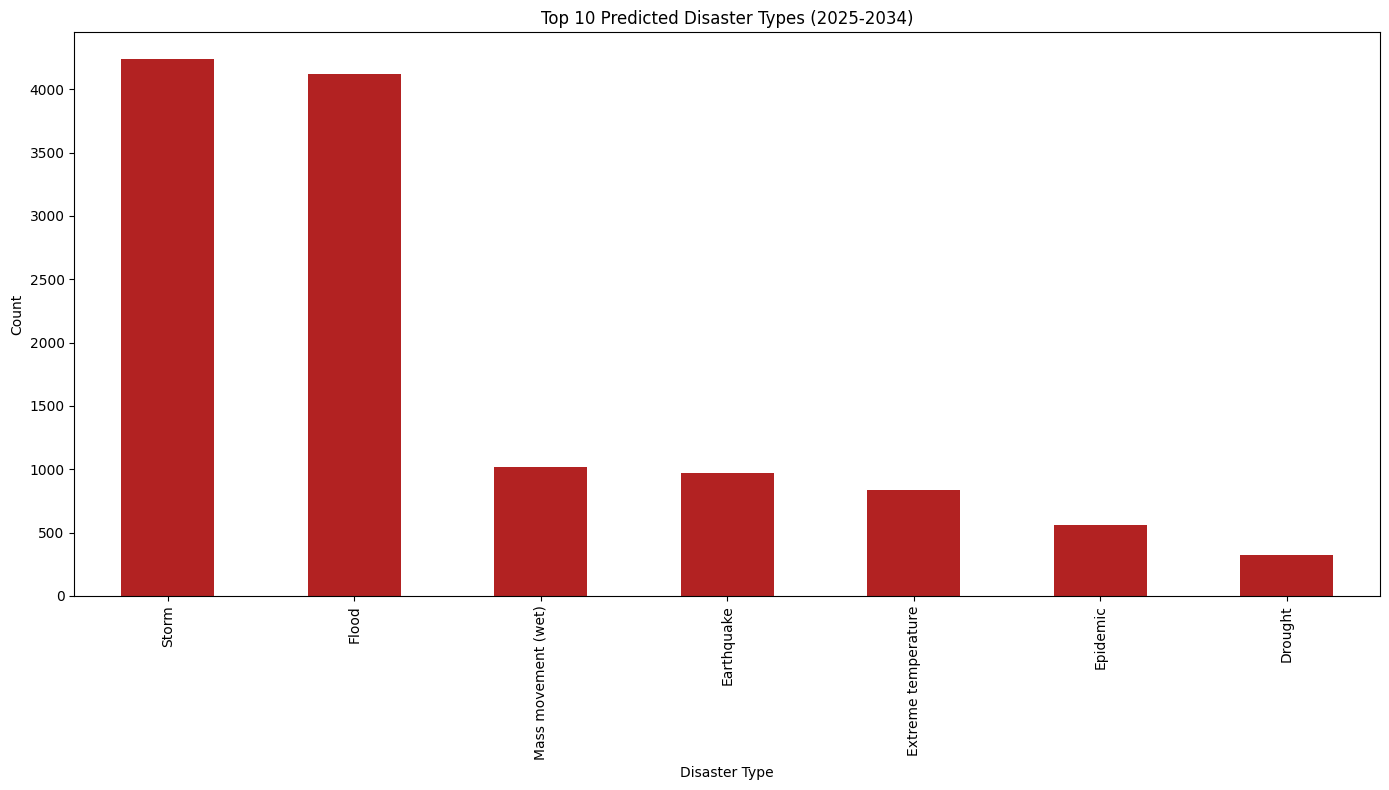

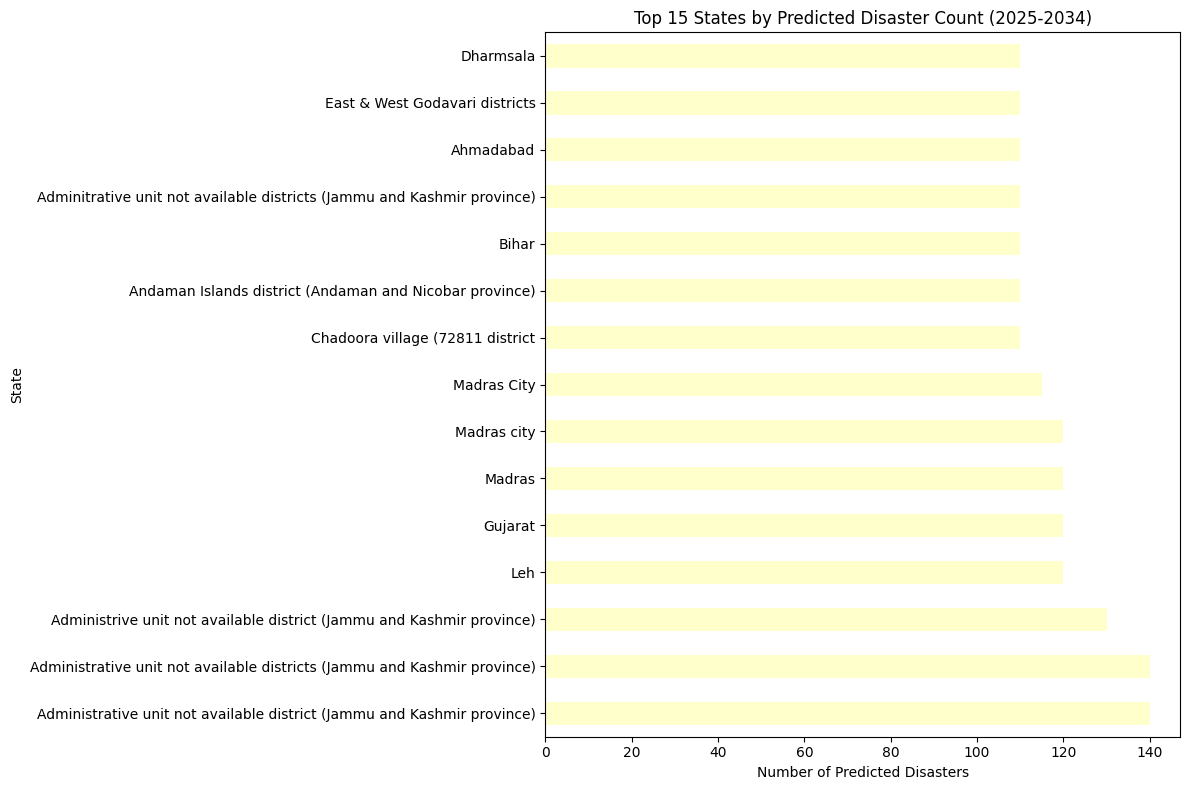

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import calendar
from sklearn.metrics import classification_report
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('disasterIND.csv', sep=',')

# Step 1: Data Exploration and Cleaning
print("Original dataset shape:", df.shape)

# Convert date columns to datetime
date_columns = ['Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create a start date column
df['Start_Date'] = pd.to_datetime(
    dict(year=df['Start Year'], month=df['Start Month'], day=df['Start Day']),
    errors='coerce'
)

# Create a simplified month column 
df['Month'] = pd.to_numeric(df['Start Month'], errors='coerce').fillna(1).astype(int)

# Create season column
def get_season(month):
    if pd.isna(month) or month == 0:
        return 'Unknown'
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Autumn'

# Apply the function to create season
df['Season'] = df['Month'].apply(get_season)

# Handle missing values for key columns
for col in ['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Location']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Step 2: Enhanced Feature Engineering
# Extract state from location
def extract_state(location_str):
    if pd.isna(location_str):
        return 'Unknown'
    
    states = [
        'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'Goa', 'Gujarat', 
        'Haryana', 'Himachal Pradesh', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 
        'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 
        'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Delhi',
        'Bengal'
    ]
    
    for state in states:
        if state.lower() in location_str.lower():
            return state
    
    return location_str.split(',')[0] if ',' in location_str else location_str

# Apply the state extraction
df['State'] = df['Location'].apply(extract_state)

# Create climate zone feature
def assign_climate_zone(state):
    # Define climate zones for Indian states
    tropical = ['Kerala', 'Tamil Nadu', 'Karnataka', 'Andhra Pradesh', 'Telangana', 'Goa']
    subtropical = ['Maharashtra', 'Madhya Pradesh', 'Chhattisgarh', 'Odisha', 'West Bengal', 'Bengal']
    arid = ['Rajasthan', 'Gujarat']
    semi_arid = ['Punjab', 'Haryana', 'Delhi', 'Uttar Pradesh']
    montane = ['Himachal Pradesh', 'Uttarakhand', 'Jammu and Kashmir', 'Sikkim', 'Arunachal Pradesh']
    humid_subtropical = ['Assam', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura', 'Bihar', 'Jharkhand']
    
    if state in tropical:
        return 'Tropical'
    elif state in subtropical:
        return 'Subtropical'
    elif state in arid:
        return 'Arid'
    elif state in semi_arid:
        return 'Semi-Arid'
    elif state in montane:
        return 'Montane'
    elif state in humid_subtropical:
        return 'Humid Subtropical'
    else:
        return 'Unknown'

df['Climate_Zone'] = df['State'].apply(assign_climate_zone)

# Create coastal state feature
coastal_states = ['Gujarat', 'Maharashtra', 'Goa', 'Karnataka', 'Kerala', 'Tamil Nadu', 
                  'Andhra Pradesh', 'Odisha', 'West Bengal', 'Bengal']
df['Is_Coastal'] = df['State'].apply(lambda x: 1 if x in coastal_states else 0)

# Create geographical region feature
def assign_region(state):
    north = ['Jammu and Kashmir', 'Himachal Pradesh', 'Punjab', 'Haryana', 'Uttarakhand', 'Delhi']
    central = ['Rajasthan', 'Uttar Pradesh', 'Madhya Pradesh', 'Chhattisgarh']
    east = ['Bihar', 'Jharkhand', 'West Bengal', 'Bengal', 'Odisha']
    northeast = ['Sikkim', 'Assam', 'Arunachal Pradesh', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura']
    west = ['Gujarat', 'Maharashtra', 'Goa']
    south = ['Karnataka', 'Telangana', 'Andhra Pradesh', 'Tamil Nadu', 'Kerala']
    
    if state in north:
        return 'North'
    elif state in central:
        return 'Central'
    elif state in east:
        return 'East'
    elif state in northeast:
        return 'Northeast'
    elif state in west:
        return 'West'
    elif state in south:
        return 'South'
    else:
        return 'Unknown'

df['Region'] = df['State'].apply(assign_region)

# Create severity indicator based on deaths and affected
df['Total Deaths'] = pd.to_numeric(df['Total Deaths'], errors='coerce').fillna(0)
df['Total Affected'] = pd.to_numeric(df['Total Affected'], errors='coerce').fillna(0)
df['Severity'] = np.log1p(df['Total Deaths'] + 0.1*df['Total Affected'])

# Step 3: Calculate disaster frequencies and patterns
# Get disaster frequency by type, state, and month
disaster_type_freq = df.groupby('Disaster Type').size().to_dict()
state_disaster_freq = df.groupby(['State', 'Disaster Type']).size().unstack(fill_value=0)
month_disaster_freq = df.groupby(['Month', 'Disaster Type']).size().unstack(fill_value=0)
season_disaster_freq = df.groupby(['Season', 'Disaster Type']).size().unstack(fill_value=0)
climate_disaster_freq = df.groupby(['Climate_Zone', 'Disaster Type']).size().unstack(fill_value=0)

# Calculate disaster periodicity
yearly_disasters = df.groupby(['Start Year', 'Disaster Type']).size().unstack(fill_value=0)
disaster_periodicity = {}

for disaster in df['Disaster Type'].unique():
    disaster_data = yearly_disasters.get(disaster, pd.Series())
    if not disaster_data.empty:
        # Find years with disasters
        years_with_disasters = disaster_data[disaster_data > 0].index.tolist()
        if len(years_with_disasters) >= 2:
            # Calculate intervals between occurrences
            intervals = [years_with_disasters[i+1] - years_with_disasters[i] 
                        for i in range(len(years_with_disasters)-1)]
            if intervals:
                avg_interval = sum(intervals) / len(intervals)
                disaster_periodicity[disaster] = round(avg_interval, 1)

print("\nAverage years between disaster occurrences:")
for disaster, period in sorted(disaster_periodicity.items()):
    print(f"{disaster}: {period} years")

# Step 4: Prepare features for prediction models
# Define features to use
features = ['Month', 'Season', 'State', 'Climate_Zone', 'Region', 'Is_Coastal']
disaster_types = df['Disaster Type'].unique()

# Create a copy of the dataframe for processing
df_proc = df.copy()

# Encode categorical variables consistently
label_encoders = {}
for column in features:
    if column in df_proc.columns and df_proc[column].dtype == 'object':
        le = LabelEncoder()
        df_proc[column] = le.fit_transform(df_proc[column])
        label_encoders[column] = le
    elif column == 'Is_Coastal':  # Already numeric
        pass

# Get the feature matrix X
X = df_proc[features].copy()

# Step 5: Build prediction models for each disaster type
disaster_models = {}
disaster_classes = {}  # Store number of classes for each disaster type model

for disaster in disaster_types:
    # Create binary target: 1 if this disaster, 0 otherwise
    y_binary = (df['Disaster Type'] == disaster).astype(int)
    
    # Check if we have enough positive samples
    positive_samples = sum(y_binary)
    if positive_samples < 5:
        print(f"Warning: Not enough samples for {disaster} ({positive_samples} found). Skipping.")
        continue
    
    # Use consistent features
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.25, random_state=42)
    
    # Train a Random Forest model for this disaster type
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Store the model
    disaster_models[disaster] = rf_model
    
    # Store number of classes - important for prediction
    disaster_classes[disaster] = len(np.unique(y_train))
    
    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    print(f"\nClassification Report for {disaster}:")
    print(classification_report(y_test, y_pred))

# Step 6: Generate future predictions for 10 years (2025-2034)
# Create future years dataframe with exactly the same columns and transformations
future_years = range(2025, 2035)  # 10 years
months = range(1, 13)
states = df['State'].unique()

future_data = []
for year in future_years:
    for month in months:
        for state in states:
            future_data.append([year, month, state])

future_df = pd.DataFrame(future_data, columns=['Year', 'Month', 'State'])

# Add derived features using the same functions as before
future_df['Season'] = future_df['Month'].apply(get_season)
future_df['Climate_Zone'] = future_df['State'].apply(assign_climate_zone)
future_df['Is_Coastal'] = future_df['State'].apply(lambda x: 1 if x in coastal_states else 0)
future_df['Region'] = future_df['State'].apply(assign_region)

# Encode categorical features using the same encoders from training
future_df_encoded = future_df.copy()
for column in features:
    if column in label_encoders:  # For categorical columns
        # Map values not seen during training to a value that was seen
        future_df_encoded[column] = future_df[column].apply(
            lambda x: x if x in label_encoders[column].classes_ else label_encoders[column].classes_[0]
        )
        future_df_encoded[column] = label_encoders[column].transform(future_df_encoded[column])

# Ensure future_X has exactly the same columns as X, in the same order
future_X = future_df_encoded[features].copy()

# Step 7: Make predictions for each disaster type
for disaster, model in disaster_models.items():
    # Check how many classes this model has - fixes the IndexError
    num_classes = disaster_classes[disaster]
    
    # Get the probabilities
    probs = model.predict_proba(future_X)
    
    # If there's only one class (all negative), set probability to 0
    if num_classes == 1 or probs.shape[1] == 1:
        future_df[f"Prob_{disaster}"] = 0
    else:
        # Otherwise use the probability of the positive class (index 1)
        future_df[f"Prob_{disaster}"] = probs[:, 1]

# Step 8: Apply more balanced adjustments for all disaster types
# Define weights for different factors - slightly reduced importance
weights = {
    'base': 0.6,      # Increased base weight 
    'season': 0.08,   # Reduced weight
    'month': 0.08,    # Reduced weight
    'state': 0.12,    # Reduced weight
    'climate': 0.04,  # Reduced weight
    'periodicity': 0.08 # Reduced weight
}

# Create a dictionary to track max probabilities by disaster type
max_probs_by_disaster = {}

for idx, row in future_df.iterrows():
    month = row['Month']
    state = row['State']
    season = row['Season']
    climate = row['Climate_Zone']
    
    for disaster in disaster_models.keys():
        base_prob = row[f"Prob_{disaster}"]
        
        # Calculate adjustment factors (even smaller values than before)
        season_factor = 1.0
        if season in season_disaster_freq.index and disaster in season_disaster_freq.columns:
            if season_disaster_freq.loc[season, disaster] > 0:
                season_factor = 1.05  # Further reduced from 1.1
        
        month_factor = 1.0
        if month in month_disaster_freq.index and disaster in month_disaster_freq.columns:
            if month_disaster_freq.loc[month, disaster] > 0:
                month_factor = 1.05  # Further reduced from 1.1
        
        state_factor = 1.0
        if state in state_disaster_freq.index and disaster in state_disaster_freq.columns:
            if state_disaster_freq.loc[state, disaster] > 0:
                state_factor = 1.08  # Further reduced from 1.2
        
        climate_factor = 1.0
        if climate in climate_disaster_freq.index and disaster in climate_disaster_freq.columns:
            if climate_disaster_freq.loc[climate, disaster] > 0:
                climate_factor = 1.03  # Further reduced from 1.05
        
        periodicity_factor = 1.0
        if disaster in disaster_periodicity:
            period = disaster_periodicity[disaster]
            last_occurrence = df[df['Disaster Type'] == disaster]['Start Year'].max()
            if not pd.isna(last_occurrence):
                years_since_last = row['Year'] - last_occurrence
                # If we're close to a predicted recurrence
                if abs(years_since_last % period) <= 1:
                    periodicity_factor = 1.07  # Further reduced from 1.15
        
        # Calculate adjusted probability using weighted average
        weighted_prob = (
            base_prob * weights['base'] +
            (base_prob * season_factor - base_prob) * weights['season'] +
            (base_prob * month_factor - base_prob) * weights['month'] +
            (base_prob * state_factor - base_prob) * weights['state'] +
            (base_prob * climate_factor - base_prob) * weights['climate'] +
            (base_prob * periodicity_factor - base_prob) * weights['periodicity']
        )
        
        # Cap at 0.90 - even lower maximum probability
        capped_prob = min(0.90, weighted_prob)
        future_df.loc[idx, f"Adj_Prob_{disaster}"] = capped_prob
        
        # Track the maximum probability for each disaster type
        if disaster not in max_probs_by_disaster or capped_prob > max_probs_by_disaster[disaster]:
            max_probs_by_disaster[disaster] = capped_prob

# Additional calibration step to prevent any disaster type from having consistently high probabilities
print("\nMaximum probability by disaster type before calibration:")
for disaster, max_prob in max_probs_by_disaster.items():
    print(f"{disaster}: {max_prob:.4f}")

# Apply a global calibration to prevent any disaster type from having consistently high probabilities
for disaster in disaster_models.keys():
    prob_col = f"Adj_Prob_{disaster}"
    max_prob = max_probs_by_disaster[disaster]
    
    # If the maximum probability is too high (above 0.8), rescale all probabilities
    if max_prob > 0.8:
        scaling_factor = 0.8 / max_prob
        future_df[prob_col] = future_df[prob_col] * scaling_factor
        print(f"Calibrated {disaster} probabilities by factor {scaling_factor:.4f}")

# Track the final maximum probabilities after calibration
final_max_probs = {}
for disaster in disaster_models.keys():
    prob_col = f"Adj_Prob_{disaster}"
    final_max_probs[disaster] = future_df[prob_col].max()

print("\nMaximum probability by disaster type after calibration:")
for disaster, max_prob in final_max_probs.items():
    print(f"{disaster}: {max_prob:.4f}")

# Step 9: Format predictions for analysis
# Get all adjusted probability columns
adj_prob_cols = [col for col in future_df.columns if col.startswith('Adj_Prob_')]

# Find the most likely disaster type for each location and time
future_df['Most_Likely_Disaster'] = future_df[adj_prob_cols].idxmax(axis=1).str.replace('Adj_Prob_', '')
future_df['Max_Probability'] = future_df[adj_prob_cols].max(axis=1)

# Create a threshold for significant disaster probability
threshold = 0.3
significant_predictions = future_df[future_df['Max_Probability'] >= threshold].copy()

# Format month as name
significant_predictions['Month_Name'] = significant_predictions['Month'].apply(
    lambda x: calendar.month_name[int(x)]
)

# Step 10: Generate comprehensive prediction table
prediction_results = []

for idx, row in significant_predictions.iterrows():
    year = row['Year']
    month = row['Month_Name']
    state = row['State']
    
    # Get all disasters with significant probability
    for disaster in disaster_models.keys():
        prob = row[f"Adj_Prob_{disaster}"]
        if prob >= threshold:
            prediction_results.append({
                'Year': year,
                'Month': month,
                'State': state,
                'Disaster Type': disaster,
                'Probability': prob,
                'Climate Zone': row['Climate_Zone'],
                'Season': row['Season'],
                'Region': row['Region']
            })

# Convert to DataFrame and sort
prediction_df = pd.DataFrame(prediction_results)
if not prediction_df.empty:
    prediction_df = prediction_df.sort_values(by=['Year', 'Month', 'State', 'Probability'], ascending=[True, True, True, False])
    
    # Format probability as percentage
    prediction_df['Probability'] = prediction_df['Probability'].apply(lambda x: f"{x:.2%}")
    
    # Save the predictions to a CSV file
    prediction_df.to_csv('comprehensive_disaster_predictions_2025_2034.csv', index=False)
    
    print("\nComprehensive Disaster Predictions for 2025-2034:")
    print(prediction_df.head(20).to_string(index=False))
    
    # Step 11: Generate location-specific disaster profiles
    location_profiles = []
    
    for state in df['State'].unique():
        state_predictions = prediction_df[prediction_df['State'] == state]
        if not state_predictions.empty:
            disaster_counts = state_predictions['Disaster Type'].value_counts()
            
            profile = {
                'State': state,
                'Climate Zone': state_predictions['Climate Zone'].iloc[0],
                'Region': state_predictions['Region'].iloc[0],
                'Total Predicted Disasters': len(state_predictions),
                'Most Common Disaster': disaster_counts.index[0],
                'Most Common Disaster Count': disaster_counts.iloc[0],
                'All Potential Disasters': ', '.join(disaster_counts.index.tolist())
            }
            location_profiles.append(profile)
    
    location_profiles_df = pd.DataFrame(location_profiles)
    if not location_profiles_df.empty:
        location_profiles_df = location_profiles_df.sort_values('Total Predicted Disasters', ascending=False)
        location_profiles_df.to_csv('location_disaster_profiles_2025_2034.csv', index=False)
        
        print("\nLocation-Specific Disaster Profiles (Top 10):")
        print(location_profiles_df.head(10).to_string(index=False))
    
    # Step 12: Generate yearly disaster summary
    yearly_summary = prediction_df.groupby(['Year', 'Disaster Type']).size().unstack(fill_value=0)
    yearly_summary.to_csv('yearly_disaster_summary_2025_2034.csv')
    
    print("\nYearly Disaster Summary (2025-2034):")
    print(yearly_summary.to_string())
    
    # Step 13: Visualize key findings
    try:
        plt.figure(figsize=(14, 8))
        disaster_counts = prediction_df['Disaster Type'].value_counts().head(10)
        disaster_counts.plot(kind='bar', color='firebrick')
        plt.title('Top 10 Predicted Disaster Types (2025-2034)')
        plt.xlabel('Disaster Type')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig('top_predicted_disasters.png')
        
        # Map of disaster hotspots
        plt.figure(figsize=(12, 8))
        state_counts = prediction_df['State'].value_counts().head(15)
        state_counts.plot(kind='barh', cmap='YlOrRd')
        plt.title('Top 15 States by Predicted Disaster Count (2025-2034)')
        plt.xlabel('Number of Predicted Disasters')
        plt.tight_layout()
        plt.savefig('state_disaster_predictions.png')
    except Exception as e:
        print(f"Warning: Could not generate some visualizations: {e}")
    
    print("\nAnalysis complete! Output files have been saved.")
else:
    print("\nNo significant disaster predictions were found for 2025-2034.")

In [7]:
import pickle

# After Step 5 where you've built the prediction models
# Save the trained models, label encoders, and related information

# Create a dictionary to store all necessary components
model_package = {
    'disaster_models': disaster_models,
    'disaster_classes': disaster_classes,
    'label_encoders': label_encoders,
    'features': features,
    'disaster_types': disaster_types,
    'disaster_periodicity': disaster_periodicity,
    'coastal_states': coastal_states
}

# Save the models and related data to a pickle file
with open('disaster_prediction_models.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Models and related data have been saved to 'disaster_prediction_models.pkl'")

Models and related data have been saved to 'disaster_prediction_models.pkl'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import calendar
from sklearn.metrics import classification_report
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('disasterIND.csv', sep=',')

# Step 1: Data Exploration and Cleaning
print("Original dataset shape:", df.shape)

# Convert date columns to datetime
date_columns = ['Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Create a start date column
df['Start_Date'] = pd.to_datetime(
    dict(year=df['Start Year'], month=df['Start Month'], day=df['Start Day']),
    errors='coerce'
)

# Create a simplified month column 
df['Month'] = pd.to_numeric(df['Start Month'], errors='coerce').fillna(1).astype(int)

# Create season column
def get_season(month):
    if pd.isna(month) or month == 0:
        return 'Unknown'
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Autumn'

# Apply the function to create season
df['Season'] = df['Month'].apply(get_season)

# Handle missing values for key columns
for col in ['Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Location']:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Step 2: Enhanced Feature Engineering
# Extract state from location
def extract_state(location_str):
    if pd.isna(location_str):
        return 'Unknown'
    
    states = [
        'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'Goa', 'Gujarat', 
        'Haryana', 'Himachal Pradesh', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 
        'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 
        'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Delhi',
        'Bengal'
    ]
    
    for state in states:
        if state.lower() in location_str.lower():
            return state
    
    return location_str.split(',')[0] if ',' in location_str else location_str

# Apply the state extraction
df['State'] = df['Location'].apply(extract_state)

# Create climate zone feature
def assign_climate_zone(state):
    # Define climate zones for Indian states
    tropical = ['Kerala', 'Tamil Nadu', 'Karnataka', 'Andhra Pradesh', 'Telangana', 'Goa']
    subtropical = ['Maharashtra', 'Madhya Pradesh', 'Chhattisgarh', 'Odisha', 'West Bengal', 'Bengal']
    arid = ['Rajasthan', 'Gujarat']
    semi_arid = ['Punjab', 'Haryana', 'Delhi', 'Uttar Pradesh']
    montane = ['Himachal Pradesh', 'Uttarakhand', 'Jammu and Kashmir', 'Sikkim', 'Arunachal Pradesh']
    humid_subtropical = ['Assam', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura', 'Bihar', 'Jharkhand']
    
    if state in tropical:
        return 'Tropical'
    elif state in subtropical:
        return 'Subtropical'
    elif state in arid:
        return 'Arid'
    elif state in semi_arid:
        return 'Semi-Arid'
    elif state in montane:
        return 'Montane'
    elif state in humid_subtropical:
        return 'Humid Subtropical'
    else:
        return 'Unknown'

df['Climate_Zone'] = df['State'].apply(assign_climate_zone)

# Create coastal state feature
coastal_states = ['Gujarat', 'Maharashtra', 'Goa', 'Karnataka', 'Kerala', 'Tamil Nadu', 
                  'Andhra Pradesh', 'Odisha', 'West Bengal', 'Bengal']
df['Is_Coastal'] = df['State'].apply(lambda x: 1 if x in coastal_states else 0)

# Create geographical region feature
def assign_region(state):
    north = ['Jammu and Kashmir', 'Himachal Pradesh', 'Punjab', 'Haryana', 'Uttarakhand', 'Delhi']
    central = ['Rajasthan', 'Uttar Pradesh', 'Madhya Pradesh', 'Chhattisgarh']
    east = ['Bihar', 'Jharkhand', 'West Bengal', 'Bengal', 'Odisha']
    northeast = ['Sikkim', 'Assam', 'Arunachal Pradesh', 'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura']
    west = ['Gujarat', 'Maharashtra', 'Goa']
    south = ['Karnataka', 'Telangana', 'Andhra Pradesh', 'Tamil Nadu', 'Kerala']
    
    if state in north:
        return 'North'
    elif state in central:
        return 'Central'
    elif state in east:
        return 'East'
    elif state in northeast:
        return 'Northeast'
    elif state in west:
        return 'West'
    elif state in south:
        return 'South'
    else:
        return 'Unknown'

df['Region'] = df['State'].apply(assign_region)

# Create severity indicator based on deaths and affected
df['Total Deaths'] = pd.to_numeric(df['Total Deaths'], errors='coerce').fillna(0)
df['Total Affected'] = pd.to_numeric(df['Total Affected'], errors='coerce').fillna(0)
df['Severity'] = np.log1p(df['Total Deaths'] + 0.1*df['Total Affected'])

# Step 3: Calculate disaster frequencies and patterns
# Get disaster frequency by type, state, and month
disaster_type_freq = df.groupby('Disaster Type').size().to_dict()
state_disaster_freq = df.groupby(['State', 'Disaster Type']).size().unstack(fill_value=0)
month_disaster_freq = df.groupby(['Month', 'Disaster Type']).size().unstack(fill_value=0)
season_disaster_freq = df.groupby(['Season', 'Disaster Type']).size().unstack(fill_value=0)
climate_disaster_freq = df.groupby(['Climate_Zone', 'Disaster Type']).size().unstack(fill_value=0)

# Calculate disaster periodicity
yearly_disasters = df.groupby(['Start Year', 'Disaster Type']).size().unstack(fill_value=0)
disaster_periodicity = {}

for disaster in df['Disaster Type'].unique():
    disaster_data = yearly_disasters.get(disaster, pd.Series())
    if not disaster_data.empty:
        # Find years with disasters
        years_with_disasters = disaster_data[disaster_data > 0].index.tolist()
        if len(years_with_disasters) >= 2:
            # Calculate intervals between occurrences
            intervals = [years_with_disasters[i+1] - years_with_disasters[i] 
                        for i in range(len(years_with_disasters)-1)]
            if intervals:
                avg_interval = sum(intervals) / len(intervals)
                disaster_periodicity[disaster] = round(avg_interval, 1)

print("\nAverage years between disaster occurrences:")
for disaster, period in sorted(disaster_periodicity.items()):
    print(f"{disaster}: {period} years")

# Step 4: Prepare features for prediction models
# Define features to use
features = ['Month', 'Season', 'State', 'Climate_Zone', 'Region', 'Is_Coastal']
disaster_types = df['Disaster Type'].unique()

# Create a copy of the dataframe for processing
df_proc = df.copy()

# Encode categorical variables consistently
# This is the critical part for solving the error
label_encoders = {}
for column in features:
    if column in df_proc.columns and df_proc[column].dtype == 'object':
        le = LabelEncoder()
        df_proc[column] = le.fit_transform(df_proc[column])
        label_encoders[column] = le
    elif column == 'Is_Coastal':  # Already numeric
        pass

# Get the feature matrix X
X = df_proc[features].copy()

# Step 5: Build prediction models for each disaster type
disaster_models = {}
for disaster in disaster_types:
    # Create binary target: 1 if this disaster, 0 otherwise
    y_binary = (df['Disaster Type'] == disaster).astype(int)
    
    # Use consistent features
    X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.25, random_state=42)
    
    # Train a Random Forest model for this disaster type
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Store the model
    disaster_models[disaster] = rf_model
    
    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    print(f"\nClassification Report for {disaster}:")
    print(classification_report(y_test, y_pred))

# Step 6: Generate future predictions for 10 years (2025-2034)
# Create future years dataframe with exactly the same columns and transformations
future_years = range(2025, 2035)  # 10 years
months = range(1, 13)
states = df['State'].unique()

future_data = []
for year in future_years:
    for month in months:
        for state in states:
            future_data.append([year, month, state])

future_df = pd.DataFrame(future_data, columns=['Year', 'Month', 'State'])

# Add derived features using the same functions as before
future_df['Season'] = future_df['Month'].apply(get_season)
future_df['Climate_Zone'] = future_df['State'].apply(assign_climate_zone)
future_df['Is_Coastal'] = future_df['State'].apply(lambda x: 1 if x in coastal_states else 0)
future_df['Region'] = future_df['State'].apply(assign_region)

# Encode categorical features using the same encoders from training
future_df_encoded = future_df.copy()
for column in features:
    if column in label_encoders:  # For categorical columns
        # Map values not seen during training to a value that was seen
        future_df_encoded[column] = future_df[column].apply(
            lambda x: x if x in label_encoders[column].classes_ else label_encoders[column].classes_[0]
        )
        future_df_encoded[column] = label_encoders[column].transform(future_df_encoded[column])

# Ensure future_X has exactly the same columns as X, in the same order
future_X = future_df_encoded[features].copy()

# Step 7: Make predictions for each disaster type
for disaster, model in disaster_models.items():
    # Predict probability of this disaster type
    future_df[f"Prob_{disaster}"] = model.predict_proba(future_X)[:, 1]

# Step 8: Apply adjustments based on historical patterns
for idx, row in future_df.iterrows():
    month = row['Month']
    state = row['State']
    season = row['Season']
    climate = row['Climate_Zone']
    
    for disaster in disaster_types:
        base_prob = row[f"Prob_{disaster}"]
        
        # Seasonal adjustment
        season_factor = 1.0
        if season in season_disaster_freq.index and disaster in season_disaster_freq.columns:
            if season_disaster_freq.loc[season, disaster] > 0:
                season_factor = 1.2
        
        # Monthly adjustment
        month_factor = 1.0
        if month in month_disaster_freq.index and disaster in month_disaster_freq.columns:
            if month_disaster_freq.loc[month, disaster] > 0:
                month_factor = 1.3
        
        # State history adjustment
        state_factor = 1.0
        if state in state_disaster_freq.index and disaster in state_disaster_freq.columns:
            if state_disaster_freq.loc[state, disaster] > 0:
                state_factor = 1.5
        
        # Climate zone adjustment
        climate_factor = 1.0
        if climate in climate_disaster_freq.index and disaster in climate_disaster_freq.columns:
            if climate_disaster_freq.loc[climate, disaster] > 0:
                climate_factor = 1.2
        
        # Apply periodicity factor if available
        periodicity_factor = 1.0
        if disaster in disaster_periodicity:
            period = disaster_periodicity[disaster]
            last_occurrence = df[df['Disaster Type'] == disaster]['Start Year'].max()
            if not pd.isna(last_occurrence):
                years_since_last = row['Year'] - last_occurrence
                # If we're close to a predicted recurrence
                if abs(years_since_last % period) <= 1:
                    periodicity_factor = 1.5
        
        # Calculate final adjusted probability
        adjusted_prob = base_prob * season_factor * month_factor * state_factor * climate_factor * periodicity_factor
        
        # Cap at 1.0
        future_df.loc[idx, f"Adj_Prob_{disaster}"] = min(1.0, adjusted_prob)

# Step 9: Format predictions for analysis
# Get all adjusted probability columns
adj_prob_cols = [col for col in future_df.columns if col.startswith('Adj_Prob_')]

# Find the most likely disaster type for each location and time
future_df['Most_Likely_Disaster'] = future_df[adj_prob_cols].idxmax(axis=1).str.replace('Adj_Prob_', '')
future_df['Max_Probability'] = future_df[adj_prob_cols].max(axis=1)

# Create a threshold for significant disaster probability
threshold = 0.3
significant_predictions = future_df[future_df['Max_Probability'] >= threshold].copy()

# Format month as name
significant_predictions['Month_Name'] = significant_predictions['Month'].apply(
    lambda x: calendar.month_name[int(x)]
)

# Step 10: Generate comprehensive prediction table
prediction_results = []

for idx, row in significant_predictions.iterrows():
    year = row['Year']
    month = row['Month_Name']
    state = row['State']
    
    # Get all disasters with significant probability
    for disaster in disaster_types:
        prob = row[f"Adj_Prob_{disaster}"]
        if prob >= threshold:
            prediction_results.append({
                'Year': year,
                'Month': month,
                'State': state,
                'Disaster Type': disaster,
                'Probability': prob,
                'Climate Zone': row['Climate_Zone'],
                'Season': row['Season'],
                'Region': row['Region']
            })

# Convert to DataFrame and sort
prediction_df = pd.DataFrame(prediction_results)
if not prediction_df.empty:
    prediction_df = prediction_df.sort_values(by=['Year', 'Month', 'State', 'Probability'], ascending=[True, True, True, False])
    
    # Format probability as percentage
    prediction_df['Probability'] = prediction_df['Probability'].apply(lambda x: f"{x:.2%}")
    
    # Save the predictions to a CSV file
    prediction_df.to_csv('comprehensive_disaster_predictions_2025_2034.csv', index=False)
    
    print("\nComprehensive Disaster Predictions for 2025-2034:")
    print(prediction_df.head(20).to_string(index=False))
    
    # Step 11: Generate location-specific disaster profiles
    location_profiles = []
    
    for state in df['State'].unique():
        state_predictions = prediction_df[prediction_df['State'] == state]
        if not state_predictions.empty:
            disaster_counts = state_predictions['Disaster Type'].value_counts()
            
            profile = {
                'State': state,
                'Climate Zone': state_predictions['Climate Zone'].iloc[0],
                'Region': state_predictions['Region'].iloc[0],
                'Total Predicted Disasters': len(state_predictions),
                'Most Common Disaster': disaster_counts.index[0],
                'Most Common Disaster Count': disaster_counts.iloc[0],
                'All Potential Disasters': ', '.join(disaster_counts.index.tolist())
            }
            location_profiles.append(profile)
    
    location_profiles_df = pd.DataFrame(location_profiles)
    if not location_profiles_df.empty:
        location_profiles_df = location_profiles_df.sort_values('Total Predicted Disasters', ascending=False)
        location_profiles_df.to_csv('location_disaster_profiles_2025_2034.csv', index=False)
        
        print("\nLocation-Specific Disaster Profiles (Top 10):")
        print(location_profiles_df.head(10).to_string(index=False))
    
    # Step 12: Generate yearly disaster summary
    yearly_summary = prediction_df.groupby(['Year', 'Disaster Type']).size().unstack(fill_value=0)
    yearly_summary.to_csv('yearly_disaster_summary_2025_2034.csv')
    
    print("\nYearly Disaster Summary (2025-2034):")
    print(yearly_summary.to_string())
    
    # Step 13: Visualize key findings
    try:
        plt.figure(figsize=(14, 8))
        disaster_counts = prediction_df['Disaster Type'].value_counts().head(10)
        disaster_counts.plot(kind='bar', color='firebrick')
        plt.title('Top 10 Predicted Disaster Types (2025-2034)')
        plt.xlabel('Disaster Type')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig('top_predicted_disasters.png')
        
        # Map of disaster hotspots
        plt.figure(figsize=(12, 8))
        state_counts = prediction_df['State'].value_counts().head(15)
        state_counts.plot(kind='barh', cmap='YlOrRd')
        plt.title('Top 15 States by Predicted Disaster Count (2025-2034)')
        plt.xlabel('Number of Predicted Disasters')
        plt.tight_layout()
        plt.savefig('state_disaster_predictions.png')
    except Exception as e:
        print(f"Warning: Could not generate some visualizations: {e}")
    
    print("\nAnalysis complete! Output files have been saved.")
else:
    print("\nNo significant disaster predictions were found for 2025-2034.")

Original dataset shape: (783, 46)

Average years between disaster occurrences:
Drought: 8.4 years
Earthquake: 5.0 years
Epidemic: 3.9 years
Extreme temperature: 1.7 years
Flood: 1.5 years
Glacial lake outburst flood: 2.0 years
Mass movement (dry): 23.0 years
Mass movement (wet): 2.2 years
Storm: 1.4 years
Wildfire: 11.3 years

Classification Report for Drought:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       192
           1       0.00      0.00      0.00         4

    accuracy                           0.97       196
   macro avg       0.49      0.49      0.49       196
weighted avg       0.96      0.97      0.96       196


Classification Report for Earthquake:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       188
           1       0.00      0.00      0.00         8

    accuracy                           0.95       196
   macro avg       0.48      0.50      0.49       19

Traceback (most recent call last):
  File "c:\Users\nishi\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
    ~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nishi\AppData\Local\Temp\ipykernel_22996\541222518.py", line 252, in <module>
    future_df[f"Prob_{disaster}"] = model.predict_proba(future_X)[:, 1]
                                    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^
IndexError: index 1 is out of bounds for axis 1 with size 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\nishi\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\interactiveshell.py", line 2168, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
        etype, value, tb, tb_offset=tb_offset
    )
  File "c:\Users\nishi\AppData\Local\Programs\Python\Python313\Lib\